In [ ]:
!pip install pycaret
!pip install catboost


  Using cached catboost-1.2.7-cp310-cp310-manylinux2014_x86_64.whl.metadata (1.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from pycaret.classification import *
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


In [ ]:
train_data = pd.read_csv('/content/sample_data/nairobi_train.csv')
train_data['Slum'].fillna(0, inplace=True)

# Changing label values from 1.0, 2.0 to 1
label_encoder = LabelEncoder()
train_data['Slum'] = label_encoder.fit_transform(train_data['Slum'])
#train_data['Slum'] = train_data['Slum'].replace([1, 2], 1)

#Drop id column, bgrn_1,2,3,4
train_data = train_data.drop(['field_1','index_right', 'id', 'bgrn_1', 'bgrn_2', 'bgrn_3', 'bgrn_4'], axis = 1)

#Get longitudes and latitudes from geometric points
train_data['long'] = ''
train_data['lat'] = ''
for i in range(len(train_data['geometry'])):
    point_str = train_data['geometry'][i]
    matches = re.findall(r'[-+]?\d*\.\d+', point_str)
    coordinates = [float(match) for match in matches]
    train_data['long'][i] = coordinates[0]
    train_data['lat'][i] = coordinates[1]

#Remove -9999 no data rows from the dataset
#train_data = train_data[~train_data.isin([-9999]).any(axis=1)]

#Drop geometry column
train_data = train_data.drop(['geometry'], axis = 1)



#Slum labels unsure
#data3 = train_data[train_data['Slum'] == 3]

#Removing Slum label 3 since it is unsure
#train_data = train_data[train_data['Slum'] != 3]

train_data = train_data.reindex(sorted(train_data.columns), axis=1)
train_data = train_data.drop(train_data.columns[0:53], axis=1)

colsNorm = train_data.columns[3:]
# # Imputing missing values
si = SimpleImputer(missing_values=0, strategy='mean')
# The StandardScaler
ss = StandardScaler()

train_data[colsNorm] = si.fit_transform(train_data[colsNorm])
train_data[colsNorm] = ss.fit_transform(train_data[colsNorm])

train_data = train_data.reindex(sorted(train_data.columns), axis=1)


In [ ]:
print(train_data.columns)


Index(['Slum', 'lat', 'long', 'resampled_fourier_sc31_mean',
       'resampled_fourier_sc31_variance', 'resampled_fourier_sc51_mean',
       'resampled_fourier_sc51_variance', 'resampled_fourier_sc71_mean',
       'resampled_fourier_sc71_variance', 'resampled_gabor_sc3_filter_1',
       ...
       'resampled_sfs_sc51_mean', 'resampled_sfs_sc51_min_line_length',
       'resampled_sfs_sc51_std', 'resampled_sfs_sc51_w_mean',
       'resampled_sfs_sc71_max_line_length',
       'resampled_sfs_sc71_max_ratio_of_orthogonal_angles',
       'resampled_sfs_sc71_mean', 'resampled_sfs_sc71_min_line_length',
       'resampled_sfs_sc71_std', 'resampled_sfs_sc71_w_mean'],
      dtype='object', length=147)


In [ ]:
valid_data = pd.read_csv('/content/sample_data/nairobi_validation.csv')
valid_data['Slum'].fillna(0, inplace=True)

# Changing label values from 1.0, 2.0 to 1
label_encoder = LabelEncoder()
valid_data['Slum'] = label_encoder.fit_transform(valid_data['Slum'])
#valid_data['Slum'] = valid_data['Slum'].replace([1, 2], 1)

#Drop id column
valid_data = valid_data.drop(['field_1','index_right', 'id', 'bgrn_1', 'bgrn_2', 'bgrn_3', 'bgrn_4'], axis = 1)

#Get longitudes and latitudes from geometric points
valid_data['long'] = ''
valid_data['lat'] = ''
for i in range(len(valid_data['geometry'])):
    point_str = valid_data['geometry'][i]
    matches = re.findall(r'[-+]?\d*\.\d+', point_str)
    coordinates = [float(match) for match in matches]
    valid_data['long'][i] = coordinates[0]
    valid_data['lat'][i] = coordinates[1]

#Remove -9999 no data rows from the dataset
#valid_data = valid_data[~valid_data.isin([-9999]).any(axis=1)]

#Drop geometry column
valid_data = valid_data.drop(['geometry'], axis = 1)

#Slum labels unsure
#data3 = valid_data[valid_data['Slum'] == 3]

#Removing Slum label 3 since it is unsure
#valid_data = valid_data[valid_data['Slum'] != 3]

valid_data = valid_data.reindex(sorted(valid_data.columns), axis=1)
valid_data = valid_data.drop(valid_data.columns[0:53], axis=1)

colsNorm = valid_data.columns[3:]

valid_data[colsNorm] = si.fit_transform(valid_data[colsNorm])
valid_data[colsNorm] = ss.fit_transform(valid_data[colsNorm])

valid_data = valid_data.reindex(sorted(valid_data.columns), axis=1)

In [ ]:
print(valid_data.columns)

Index(['Slum', 'lat', 'long', 'resampled_fourier_sc31_mean',
       'resampled_fourier_sc31_variance', 'resampled_fourier_sc51_mean',
       'resampled_fourier_sc51_variance', 'resampled_fourier_sc71_mean',
       'resampled_fourier_sc71_variance', 'resampled_gabor_sc3_filter_1',
       ...
       'resampled_sfs_sc51_mean', 'resampled_sfs_sc51_min_line_length',
       'resampled_sfs_sc51_std', 'resampled_sfs_sc51_w_mean',
       'resampled_sfs_sc71_max_line_length',
       'resampled_sfs_sc71_max_ratio_of_orthogonal_angles',
       'resampled_sfs_sc71_mean', 'resampled_sfs_sc71_min_line_length',
       'resampled_sfs_sc71_std', 'resampled_sfs_sc71_w_mean'],
      dtype='object', length=147)


In [ ]:
clf1 = setup(train_data, target = 'Slum', fold_strategy='groupkfold', fold=5, fold_groups=train_data['long'], session_id=123, verbose=False)
best_model = compare_models()



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9497,0.9792,0.8106,0.9006,0.8521,0.8219,0.8243,5.1220
xgboost,Extreme Gradient Boosting,0.9494,0.9780,0.7888,0.9182,0.8475,0.8175,0.8215,1.9520
catboost,CatBoost Classifier,0.9461,0.9785,0.7694,0.9187,0.8354,0.8037,0.8094,40.9720
gbc,Gradient Boosting Classifier,0.9357,0.9680,0.7187,0.9054,0.7996,0.7620,0.7704,13.2520
ada,Ada Boost Classifier,0.9104,0.9487,0.6628,0.8058,0.7255,0.6727,0.6784,2.7300
rf,Random Forest Classifier,0.9016,0.9441,0.5066,0.9033,0.6480,0.5962,0.6305,2.3560
et,Extra Trees Classifier,0.8990,0.9325,0.4888,0.9061,0.6339,0.5816,0.6195,0.6020
dt,Decision Tree Classifier,0.8925,0.8171,0.6994,0.7018,0.6995,0.6342,0.6349,0.4200
lda,Linear Discriminant Analysis,0.8880,0.8858,0.6024,0.7343,0.6594,0.5932,0.5989,0.1540
ridge,Ridge Classifier,0.8825,0.8812,0.4483,0.8183,0.5784,0.5166,0.5488,0.1220


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
# save experiment
save_experiment('my_saved_experiment_nairobi_contextual')

In [ ]:
#Logistic Regression
lr = create_model('lr')
predict_model(lr, data = valid_data)



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8685,0.8784,0.5398,0.6778,0.6010,0.5235,0.5283
1,0.8750,0.8882,0.4673,0.7143,0.5650,0.4957,0.5109
2,0.8815,0.8854,0.4907,0.7465,0.5922,0.5263,0.5422
3,0.9010,0.9096,0.5752,0.8333,0.6806,0.6243,0.6394
4,0.8653,0.8669,0.4286,0.7164,0.5363,0.4633,0.4842
Mean,0.8782,0.8857,0.5003,0.7377,0.5950,0.5266,0.5410
Std,0.0127,0.0140,0.0520,0.0526,0.0484,0.0539,0.0529


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8688,0.8487,0.5046,0.5189,0.5116,0.4358,0.4359


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.221679,36.821653,0.087063,0.206674,0.001012,-0.028633,-0.144188,-0.070624,-0.677545,-0.348787,...,-0.150061,0.687620,-0.483412,1.952891,-0.283794,1.870580,-0.076072,0,0,0.9079
1,-1.221679,36.822651,0.093272,0.196520,-0.040758,-0.078078,-0.140277,-0.167289,-0.499702,-0.351880,...,-0.225728,0.732647,-0.532967,1.814269,-0.283794,1.745458,-0.137148,0,0,0.8504
2,-1.221679,36.823649,0.029840,0.027401,-0.043328,-0.094310,-0.103735,-0.289666,-0.146114,-0.271211,...,-0.334429,0.259669,-0.753676,0.901496,-0.283794,0.819331,-0.334786,0,0,0.7243
3,-1.221679,36.824647,0.060955,-0.099511,0.012671,-0.207075,-0.111311,-0.358133,-0.541241,-0.363451,...,-0.216060,0.388177,-0.747204,1.607137,-0.283794,1.437175,-0.141429,0,0,0.9042
4,-1.221679,36.825645,0.085679,-0.088029,-0.050611,-0.197526,0.024879,-0.163513,-0.569946,-0.366298,...,-0.213834,-0.004976,-0.698042,0.790432,-0.283794,0.727802,-0.012316,0,0,0.9149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.251606,36.878791,0.397128,0.198677,0.525928,0.300391,0.655023,0.213150,0.592617,-0.314010,...,-0.343043,0.038666,-0.758280,1.163264,-0.283794,1.012336,-0.374494,1,0,0.7626
796,-1.251606,36.879789,0.337646,0.154029,0.462745,0.129315,0.646712,0.114823,0.711011,-0.283842,...,-0.367714,-0.152241,-0.758450,0.803070,-0.283794,0.698202,-0.419001,1,0,0.5232
797,-1.251606,36.880787,0.545346,0.091296,0.521004,-0.002034,0.546353,0.042963,0.522207,-0.090780,...,-0.409403,-0.416377,-0.758450,0.207007,-0.283794,0.171147,-0.447534,1,1,0.8125
798,-1.251606,36.881785,0.716366,-0.051835,0.553602,-0.060807,0.525838,-0.020327,0.414593,-0.158205,...,-0.428943,-0.360555,-0.754647,0.225354,-0.283794,0.176485,-0.478592,1,1,0.8384


In [ ]:
#Random Forest
rf = create_model('rf')
predict_model(rf, data = valid_data)



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8945,0.9410,0.5044,0.8636,0.6369,0.5801,0.6088
1,0.8994,0.9458,0.5047,0.8571,0.6353,0.5814,0.6089
2,0.9172,0.9385,0.5556,0.9524,0.7018,0.6575,0.6898
3,0.9107,0.9687,0.5487,0.9394,0.6927,0.6447,0.6766
4,0.8864,0.9265,0.4196,0.9038,0.5732,0.5175,0.5684
Mean,0.9016,0.9441,0.5066,0.9033,0.6480,0.5962,0.6305
Std,0.0111,0.0139,0.0484,0.0385,0.0464,0.0505,0.0457


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8888,0.8931,0.3028,0.7174,0.4258,0.3753,0.4184


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.221679,36.821653,0.087063,0.206674,0.001012,-0.028633,-0.144188,-0.070624,-0.677545,-0.348787,...,-0.150061,0.687620,-0.483412,1.952891,-0.283794,1.870580,-0.076072,0,0,0.91
1,-1.221679,36.822651,0.093272,0.196520,-0.040758,-0.078078,-0.140277,-0.167289,-0.499702,-0.351880,...,-0.225728,0.732647,-0.532967,1.814269,-0.283794,1.745458,-0.137148,0,0,0.82
2,-1.221679,36.823649,0.029840,0.027401,-0.043328,-0.094310,-0.103735,-0.289666,-0.146114,-0.271211,...,-0.334429,0.259669,-0.753676,0.901496,-0.283794,0.819331,-0.334786,0,0,0.80
3,-1.221679,36.824647,0.060955,-0.099511,0.012671,-0.207075,-0.111311,-0.358133,-0.541241,-0.363451,...,-0.216060,0.388177,-0.747204,1.607137,-0.283794,1.437175,-0.141429,0,0,0.91
4,-1.221679,36.825645,0.085679,-0.088029,-0.050611,-0.197526,0.024879,-0.163513,-0.569946,-0.366298,...,-0.213834,-0.004976,-0.698042,0.790432,-0.283794,0.727802,-0.012316,0,0,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.251606,36.878791,0.397128,0.198677,0.525928,0.300391,0.655023,0.213150,0.592617,-0.314010,...,-0.343043,0.038666,-0.758280,1.163264,-0.283794,1.012336,-0.374494,1,0,0.50
796,-1.251606,36.879789,0.337646,0.154029,0.462745,0.129315,0.646712,0.114823,0.711011,-0.283842,...,-0.367714,-0.152241,-0.758450,0.803070,-0.283794,0.698202,-0.419001,1,0,0.50
797,-1.251606,36.880787,0.545346,0.091296,0.521004,-0.002034,0.546353,0.042963,0.522207,-0.090780,...,-0.409403,-0.416377,-0.758450,0.207007,-0.283794,0.171147,-0.447534,1,1,0.53
798,-1.251606,36.881785,0.716366,-0.051835,0.553602,-0.060807,0.525838,-0.020327,0.414593,-0.158205,...,-0.428943,-0.360555,-0.754647,0.225354,-0.283794,0.176485,-0.478592,1,1,0.60


In [ ]:
#K Nearest Neighbors
knn = create_model('knn')
predict_model(knn, data = valid_data)




,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8669,0.8405,0.4159,0.7460,0.5341,0.4637,0.4906
1,0.8669,0.8288,0.3832,0.7193,0.5000,0.4313,0.4599
2,0.8718,0.8342,0.4722,0.6986,0.5635,0.4916,0.5046
3,0.8896,0.8829,0.5044,0.8261,0.6264,0.5660,0.5897
4,0.8490,0.8334,0.3750,0.6462,0.4746,0.3936,0.4135
Mean,0.8688,0.8440,0.4302,0.7272,0.5397,0.4692,0.4917
Std,0.0130,0.0198,0.0505,0.0593,0.0528,0.0584,0.0582


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.8175,0.6193,0.0917,0.1754,0.1205,0.0297,0.0316


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.221679,36.821653,0.087063,0.206674,0.001012,-0.028633,-0.144188,-0.070624,-0.677545,-0.348787,...,-0.150061,0.687620,-0.483412,1.952891,-0.283794,1.870580,-0.076072,0,0,1.0
1,-1.221679,36.822651,0.093272,0.196520,-0.040758,-0.078078,-0.140277,-0.167289,-0.499702,-0.351880,...,-0.225728,0.732647,-0.532967,1.814269,-0.283794,1.745458,-0.137148,0,0,0.6
2,-1.221679,36.823649,0.029840,0.027401,-0.043328,-0.094310,-0.103735,-0.289666,-0.146114,-0.271211,...,-0.334429,0.259669,-0.753676,0.901496,-0.283794,0.819331,-0.334786,0,0,0.6
3,-1.221679,36.824647,0.060955,-0.099511,0.012671,-0.207075,-0.111311,-0.358133,-0.541241,-0.363451,...,-0.216060,0.388177,-0.747204,1.607137,-0.283794,1.437175,-0.141429,0,0,1.0
4,-1.221679,36.825645,0.085679,-0.088029,-0.050611,-0.197526,0.024879,-0.163513,-0.569946,-0.366298,...,-0.213834,-0.004976,-0.698042,0.790432,-0.283794,0.727802,-0.012316,0,0,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.251606,36.878791,0.397128,0.198677,0.525928,0.300391,0.655023,0.213150,0.592617,-0.314010,...,-0.343043,0.038666,-0.758280,1.163264,-0.283794,1.012336,-0.374494,1,0,1.0
796,-1.251606,36.879789,0.337646,0.154029,0.462745,0.129315,0.646712,0.114823,0.711011,-0.283842,...,-0.367714,-0.152241,-0.758450,0.803070,-0.283794,0.698202,-0.419001,1,0,1.0
797,-1.251606,36.880787,0.545346,0.091296,0.521004,-0.002034,0.546353,0.042963,0.522207,-0.090780,...,-0.409403,-0.416377,-0.758450,0.207007,-0.283794,0.171147,-0.447534,1,0,0.8
798,-1.251606,36.881785,0.716366,-0.051835,0.553602,-0.060807,0.525838,-0.020327,0.414593,-0.158205,...,-0.428943,-0.360555,-0.754647,0.225354,-0.283794,0.176485,-0.478592,1,0,1.0


In [ ]:
#Decision Trees
dt = create_model('dt')
predict_model(dt, data = valid_data)




,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8896,0.8363,0.7522,0.6800,0.7143,0.6461,0.6474
1,0.8945,0.8328,0.7383,0.6810,0.7085,0.6442,0.6450
2,0.8782,0.7767,0.6204,0.6634,0.6411,0.5679,0.5684
3,0.9123,0.8434,0.7345,0.7757,0.7545,0.7012,0.7016
4,0.8880,0.7961,0.6518,0.7087,0.6791,0.6114,0.6122
Mean,0.8925,0.8171,0.6994,0.7018,0.6995,0.6342,0.6349
Std,0.0112,0.0260,0.0530,0.0397,0.0378,0.0439,0.0439


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.8062,0.7449,0.6606,0.3789,0.4816,0.3730,0.3948


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.221679,36.821653,0.087063,0.206674,0.001012,-0.028633,-0.144188,-0.070624,-0.677545,-0.348787,...,-0.150061,0.687620,-0.483412,1.952891,-0.283794,1.870580,-0.076072,0,0,1.0
1,-1.221679,36.822651,0.093272,0.196520,-0.040758,-0.078078,-0.140277,-0.167289,-0.499702,-0.351880,...,-0.225728,0.732647,-0.532967,1.814269,-0.283794,1.745458,-0.137148,0,0,1.0
2,-1.221679,36.823649,0.029840,0.027401,-0.043328,-0.094310,-0.103735,-0.289666,-0.146114,-0.271211,...,-0.334429,0.259669,-0.753676,0.901496,-0.283794,0.819331,-0.334786,0,0,1.0
3,-1.221679,36.824647,0.060955,-0.099511,0.012671,-0.207075,-0.111311,-0.358133,-0.541241,-0.363451,...,-0.216060,0.388177,-0.747204,1.607137,-0.283794,1.437175,-0.141429,0,0,1.0
4,-1.221679,36.825645,0.085679,-0.088029,-0.050611,-0.197526,0.024879,-0.163513,-0.569946,-0.366298,...,-0.213834,-0.004976,-0.698042,0.790432,-0.283794,0.727802,-0.012316,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.251606,36.878791,0.397128,0.198677,0.525928,0.300391,0.655023,0.213150,0.592617,-0.314010,...,-0.343043,0.038666,-0.758280,1.163264,-0.283794,1.012336,-0.374494,1,1,1.0
796,-1.251606,36.879789,0.337646,0.154029,0.462745,0.129315,0.646712,0.114823,0.711011,-0.283842,...,-0.367714,-0.152241,-0.758450,0.803070,-0.283794,0.698202,-0.419001,1,1,1.0
797,-1.251606,36.880787,0.545346,0.091296,0.521004,-0.002034,0.546353,0.042963,0.522207,-0.090780,...,-0.409403,-0.416377,-0.758450,0.207007,-0.283794,0.171147,-0.447534,1,1,1.0
798,-1.251606,36.881785,0.716366,-0.051835,0.553602,-0.060807,0.525838,-0.020327,0.414593,-0.158205,...,-0.428943,-0.360555,-0.754647,0.225354,-0.283794,0.176485,-0.478592,1,1,1.0


In [ ]:
#Ridge Classifier
ridge = create_model('ridge')
predict_model(ridge, data = valid_data)




,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8685,0.8687,0.4602,0.7222,0.5622,0.4892,0.5064
1,0.8766,0.8803,0.4112,0.7719,0.5366,0.4729,0.5042
2,0.8977,0.9020,0.4815,0.8814,0.6228,0.5694,0.6043
3,0.9058,0.9016,0.4956,0.9825,0.6588,0.6110,0.6592
4,0.8636,0.8535,0.3929,0.7333,0.5116,0.4407,0.4697
Mean,0.8825,0.8812,0.4483,0.8183,0.5784,0.5166,0.5488
Std,0.0165,0.0188,0.0398,0.0995,0.0546,0.0634,0.0711


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.8912,0.6511,0.3211,0.7292,0.4459,0.3955,0.4367


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_std,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label
0,-1.221679,36.821653,0.087063,0.206674,0.001012,-0.028633,-0.144188,-0.070624,-0.677545,-0.348787,...,1.708058,-0.150061,0.687620,-0.483412,1.952891,-0.283794,1.870580,-0.076072,0,0
1,-1.221679,36.822651,0.093272,0.196520,-0.040758,-0.078078,-0.140277,-0.167289,-0.499702,-0.351880,...,2.123616,-0.225728,0.732647,-0.532967,1.814269,-0.283794,1.745458,-0.137148,0,0
2,-1.221679,36.823649,0.029840,0.027401,-0.043328,-0.094310,-0.103735,-0.289666,-0.146114,-0.271211,...,1.392925,-0.334429,0.259669,-0.753676,0.901496,-0.283794,0.819331,-0.334786,0,0
3,-1.221679,36.824647,0.060955,-0.099511,0.012671,-0.207075,-0.111311,-0.358133,-0.541241,-0.363451,...,2.039500,-0.216060,0.388177,-0.747204,1.607137,-0.283794,1.437175,-0.141429,0,0
4,-1.221679,36.825645,0.085679,-0.088029,-0.050611,-0.197526,0.024879,-0.163513,-0.569946,-0.366298,...,2.099380,-0.213834,-0.004976,-0.698042,0.790432,-0.283794,0.727802,-0.012316,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.251606,36.878791,0.397128,0.198677,0.525928,0.300391,0.655023,0.213150,0.592617,-0.314010,...,1.287203,-0.343043,0.038666,-0.758280,1.163264,-0.283794,1.012336,-0.374494,1,0
796,-1.251606,36.879789,0.337646,0.154029,0.462745,0.129315,0.646712,0.114823,0.711011,-0.283842,...,0.855884,-0.367714,-0.152241,-0.758450,0.803070,-0.283794,0.698202,-0.419001,1,0
797,-1.251606,36.880787,0.545346,0.091296,0.521004,-0.002034,0.546353,0.042963,0.522207,-0.090780,...,0.657798,-0.409403,-0.416377,-0.758450,0.207007,-0.283794,0.171147,-0.447534,1,1
798,-1.251606,36.881785,0.716366,-0.051835,0.553602,-0.060807,0.525838,-0.020327,0.414593,-0.158205,...,0.896847,-0.428943,-0.360555,-0.754647,0.225354,-0.283794,0.176485,-0.478592,1,1


In [ ]:
#Quadratic Discriminant Analysis
qda = create_model('qda')
predict_model(qda, data = valid_data)




,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7321,0.8444,0.7611,0.3839,0.5104,0.3525,0.3916
1,0.7127,0.8127,0.7570,0.3491,0.4779,0.3150,0.3599
2,0.7062,0.8028,0.7130,0.3392,0.4597,0.2913,0.3292
3,0.7273,0.8422,0.7788,0.3810,0.5116,0.3520,0.3953
4,0.7338,0.8644,0.7946,0.3870,0.5205,0.3652,0.4106
Mean,0.7224,0.8333,0.7609,0.3680,0.4960,0.3352,0.3773
Std,0.0110,0.0225,0.0275,0.0198,0.0232,0.0276,0.0291


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.8638,0.6634,0.0000,0.0000,0.0000,0.0000,0.0000


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.221679,36.821653,0.087063,0.206674,0.001012,-0.028633,-0.144188,-0.070624,-0.677545,-0.348787,...,-0.150061,0.687620,-0.483412,1.952891,-0.283794,1.870580,-0.076072,0,0,1.0
1,-1.221679,36.822651,0.093272,0.196520,-0.040758,-0.078078,-0.140277,-0.167289,-0.499702,-0.351880,...,-0.225728,0.732647,-0.532967,1.814269,-0.283794,1.745458,-0.137148,0,0,1.0
2,-1.221679,36.823649,0.029840,0.027401,-0.043328,-0.094310,-0.103735,-0.289666,-0.146114,-0.271211,...,-0.334429,0.259669,-0.753676,0.901496,-0.283794,0.819331,-0.334786,0,0,1.0
3,-1.221679,36.824647,0.060955,-0.099511,0.012671,-0.207075,-0.111311,-0.358133,-0.541241,-0.363451,...,-0.216060,0.388177,-0.747204,1.607137,-0.283794,1.437175,-0.141429,0,0,1.0
4,-1.221679,36.825645,0.085679,-0.088029,-0.050611,-0.197526,0.024879,-0.163513,-0.569946,-0.366298,...,-0.213834,-0.004976,-0.698042,0.790432,-0.283794,0.727802,-0.012316,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.251606,36.878791,0.397128,0.198677,0.525928,0.300391,0.655023,0.213150,0.592617,-0.314010,...,-0.343043,0.038666,-0.758280,1.163264,-0.283794,1.012336,-0.374494,1,0,1.0
796,-1.251606,36.879789,0.337646,0.154029,0.462745,0.129315,0.646712,0.114823,0.711011,-0.283842,...,-0.367714,-0.152241,-0.758450,0.803070,-0.283794,0.698202,-0.419001,1,0,1.0
797,-1.251606,36.880787,0.545346,0.091296,0.521004,-0.002034,0.546353,0.042963,0.522207,-0.090780,...,-0.409403,-0.416377,-0.758450,0.207007,-0.283794,0.171147,-0.447534,1,0,1.0
798,-1.251606,36.881785,0.716366,-0.051835,0.553602,-0.060807,0.525838,-0.020327,0.414593,-0.158205,...,-0.428943,-0.360555,-0.754647,0.225354,-0.283794,0.176485,-0.478592,1,0,1.0


In [ ]:
#Ada Boost Classifier
ada = create_model('ada')
predict_model(ada, data = valid_data)



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9042,0.9538,0.6726,0.7755,0.7204,0.6629,0.6654
1,0.9205,0.9418,0.7477,0.7843,0.7656,0.7177,0.7180
2,0.9188,0.9355,0.6852,0.8222,0.7475,0.6996,0.7037
3,0.9172,0.9590,0.6460,0.8690,0.7411,0.6931,0.7039
4,0.8912,0.9535,0.5625,0.7778,0.6528,0.5903,0.6012
Mean,0.9104,0.9487,0.6628,0.8058,0.7255,0.6727,0.6784
Std,0.0112,0.0087,0.0602,0.0359,0.0391,0.0448,0.0424


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.8700,0.8546,0.5872,0.5203,0.5517,0.4760,0.4772


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.221679,36.821653,0.087063,0.206674,0.001012,-0.028633,-0.144188,-0.070624,-0.677545,-0.348787,...,-0.150061,0.687620,-0.483412,1.952891,-0.283794,1.870580,-0.076072,0,0,0.5094
1,-1.221679,36.822651,0.093272,0.196520,-0.040758,-0.078078,-0.140277,-0.167289,-0.499702,-0.351880,...,-0.225728,0.732647,-0.532967,1.814269,-0.283794,1.745458,-0.137148,0,0,0.5094
2,-1.221679,36.823649,0.029840,0.027401,-0.043328,-0.094310,-0.103735,-0.289666,-0.146114,-0.271211,...,-0.334429,0.259669,-0.753676,0.901496,-0.283794,0.819331,-0.334786,0,0,0.5121
3,-1.221679,36.824647,0.060955,-0.099511,0.012671,-0.207075,-0.111311,-0.358133,-0.541241,-0.363451,...,-0.216060,0.388177,-0.747204,1.607137,-0.283794,1.437175,-0.141429,0,0,0.5118
4,-1.221679,36.825645,0.085679,-0.088029,-0.050611,-0.197526,0.024879,-0.163513,-0.569946,-0.366298,...,-0.213834,-0.004976,-0.698042,0.790432,-0.283794,0.727802,-0.012316,0,0,0.5202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.251606,36.878791,0.397128,0.198677,0.525928,0.300391,0.655023,0.213150,0.592617,-0.314010,...,-0.343043,0.038666,-0.758280,1.163264,-0.283794,1.012336,-0.374494,1,1,0.5144
796,-1.251606,36.879789,0.337646,0.154029,0.462745,0.129315,0.646712,0.114823,0.711011,-0.283842,...,-0.367714,-0.152241,-0.758450,0.803070,-0.283794,0.698202,-0.419001,1,1,0.5052
797,-1.251606,36.880787,0.545346,0.091296,0.521004,-0.002034,0.546353,0.042963,0.522207,-0.090780,...,-0.409403,-0.416377,-0.758450,0.207007,-0.283794,0.171147,-0.447534,1,1,0.5052
798,-1.251606,36.881785,0.716366,-0.051835,0.553602,-0.060807,0.525838,-0.020327,0.414593,-0.158205,...,-0.428943,-0.360555,-0.754647,0.225354,-0.283794,0.176485,-0.478592,1,1,0.5082


In [ ]:
#Gradient Boosting Classifier
gbc = create_model('gbc')
predict_model(gbc, data = valid_data)



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9399,0.9777,0.7257,0.9318,0.8159,0.7807,0.7894
1,0.9416,0.9652,0.7944,0.8586,0.8252,0.7902,0.7911
2,0.9399,0.9555,0.7407,0.8989,0.8122,0.7768,0.7820
3,0.9416,0.9751,0.7168,0.9529,0.8182,0.7842,0.7955
4,0.9156,0.9666,0.6161,0.8846,0.7263,0.6783,0.6938
Mean,0.9357,0.9680,0.7187,0.9054,0.7996,0.7620,0.7704
Std,0.0101,0.0079,0.0580,0.0335,0.0369,0.0421,0.0385


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8900,0.9130,0.3394,0.6981,0.4568,0.4036,0.4363


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.221679,36.821653,0.087063,0.206674,0.001012,-0.028633,-0.144188,-0.070624,-0.677545,-0.348787,...,-0.150061,0.687620,-0.483412,1.952891,-0.283794,1.870580,-0.076072,0,0,0.9585
1,-1.221679,36.822651,0.093272,0.196520,-0.040758,-0.078078,-0.140277,-0.167289,-0.499702,-0.351880,...,-0.225728,0.732647,-0.532967,1.814269,-0.283794,1.745458,-0.137148,0,0,0.9637
2,-1.221679,36.823649,0.029840,0.027401,-0.043328,-0.094310,-0.103735,-0.289666,-0.146114,-0.271211,...,-0.334429,0.259669,-0.753676,0.901496,-0.283794,0.819331,-0.334786,0,0,0.9467
3,-1.221679,36.824647,0.060955,-0.099511,0.012671,-0.207075,-0.111311,-0.358133,-0.541241,-0.363451,...,-0.216060,0.388177,-0.747204,1.607137,-0.283794,1.437175,-0.141429,0,0,0.9793
4,-1.221679,36.825645,0.085679,-0.088029,-0.050611,-0.197526,0.024879,-0.163513,-0.569946,-0.366298,...,-0.213834,-0.004976,-0.698042,0.790432,-0.283794,0.727802,-0.012316,0,0,0.9843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.251606,36.878791,0.397128,0.198677,0.525928,0.300391,0.655023,0.213150,0.592617,-0.314010,...,-0.343043,0.038666,-0.758280,1.163264,-0.283794,1.012336,-0.374494,1,1,0.5151
796,-1.251606,36.879789,0.337646,0.154029,0.462745,0.129315,0.646712,0.114823,0.711011,-0.283842,...,-0.367714,-0.152241,-0.758450,0.803070,-0.283794,0.698202,-0.419001,1,1,0.5473
797,-1.251606,36.880787,0.545346,0.091296,0.521004,-0.002034,0.546353,0.042963,0.522207,-0.090780,...,-0.409403,-0.416377,-0.758450,0.207007,-0.283794,0.171147,-0.447534,1,0,0.5396
798,-1.251606,36.881785,0.716366,-0.051835,0.553602,-0.060807,0.525838,-0.020327,0.414593,-0.158205,...,-0.428943,-0.360555,-0.754647,0.225354,-0.283794,0.176485,-0.478592,1,0,0.5594


In [ ]:
#Extra Trees Classifier
et = create_model('et')
predict_model(et, data = valid_data)



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8945,0.9206,0.4779,0.9000,0.6243,0.5695,0.6082
1,0.9042,0.9415,0.5234,0.8750,0.6550,0.6034,0.6303
2,0.9091,0.9339,0.5278,0.9194,0.6706,0.6223,0.6546
3,0.9026,0.9591,0.5044,0.9344,0.6552,0.6043,0.6433
4,0.8847,0.9073,0.4107,0.9020,0.5644,0.5085,0.5610
Mean,0.8990,0.9325,0.4888,0.9061,0.6339,0.5816,0.6195
Std,0.0086,0.0177,0.0428,0.0200,0.0378,0.0403,0.0331


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8650,0.8662,0.0550,0.5455,0.1000,0.0769,0.1408


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.221679,36.821653,0.087063,0.206674,0.001012,-0.028633,-0.144188,-0.070624,-0.677545,-0.348787,...,-0.150061,0.687620,-0.483412,1.952891,-0.283794,1.870580,-0.076072,0,0,0.96
1,-1.221679,36.822651,0.093272,0.196520,-0.040758,-0.078078,-0.140277,-0.167289,-0.499702,-0.351880,...,-0.225728,0.732647,-0.532967,1.814269,-0.283794,1.745458,-0.137148,0,0,0.85
2,-1.221679,36.823649,0.029840,0.027401,-0.043328,-0.094310,-0.103735,-0.289666,-0.146114,-0.271211,...,-0.334429,0.259669,-0.753676,0.901496,-0.283794,0.819331,-0.334786,0,0,0.77
3,-1.221679,36.824647,0.060955,-0.099511,0.012671,-0.207075,-0.111311,-0.358133,-0.541241,-0.363451,...,-0.216060,0.388177,-0.747204,1.607137,-0.283794,1.437175,-0.141429,0,0,0.88
4,-1.221679,36.825645,0.085679,-0.088029,-0.050611,-0.197526,0.024879,-0.163513,-0.569946,-0.366298,...,-0.213834,-0.004976,-0.698042,0.790432,-0.283794,0.727802,-0.012316,0,0,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.251606,36.878791,0.397128,0.198677,0.525928,0.300391,0.655023,0.213150,0.592617,-0.314010,...,-0.343043,0.038666,-0.758280,1.163264,-0.283794,1.012336,-0.374494,1,0,0.72
796,-1.251606,36.879789,0.337646,0.154029,0.462745,0.129315,0.646712,0.114823,0.711011,-0.283842,...,-0.367714,-0.152241,-0.758450,0.803070,-0.283794,0.698202,-0.419001,1,0,0.57
797,-1.251606,36.880787,0.545346,0.091296,0.521004,-0.002034,0.546353,0.042963,0.522207,-0.090780,...,-0.409403,-0.416377,-0.758450,0.207007,-0.283794,0.171147,-0.447534,1,0,0.59
798,-1.251606,36.881785,0.716366,-0.051835,0.553602,-0.060807,0.525838,-0.020327,0.414593,-0.158205,...,-0.428943,-0.360555,-0.754647,0.225354,-0.283794,0.176485,-0.478592,1,0,0.50


In [ ]:
#Light Gradient Boosting Machine
lightgbm = create_model('lightgbm')
predict_model(lightgbm, data = valid_data)



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9481,0.9835,0.7876,0.9175,0.8476,0.8165,0.8200
1,0.9545,0.9809,0.8785,0.8624,0.8704,0.8428,0.8429
2,0.9481,0.9702,0.7870,0.9043,0.8416,0.8107,0.8135
3,0.9545,0.9776,0.8407,0.9048,0.8716,0.8440,0.8448
4,0.9432,0.9840,0.7589,0.9140,0.8293,0.7955,0.8005
Mean,0.9497,0.9792,0.8106,0.9006,0.8521,0.8219,0.8243
Std,0.0044,0.0051,0.0431,0.0198,0.0165,0.0188,0.0171


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9038,0.9126,0.4679,0.7286,0.5698,0.5185,0.5347


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.221679,36.821653,0.087063,0.206674,0.001012,-0.028633,-0.144188,-0.070624,-0.677545,-0.348787,...,-0.150061,0.687620,-0.483412,1.952891,-0.283794,1.870580,-0.076072,0,0,0.9975
1,-1.221679,36.822651,0.093272,0.196520,-0.040758,-0.078078,-0.140277,-0.167289,-0.499702,-0.351880,...,-0.225728,0.732647,-0.532967,1.814269,-0.283794,1.745458,-0.137148,0,0,0.9982
2,-1.221679,36.823649,0.029840,0.027401,-0.043328,-0.094310,-0.103735,-0.289666,-0.146114,-0.271211,...,-0.334429,0.259669,-0.753676,0.901496,-0.283794,0.819331,-0.334786,0,0,0.9975
3,-1.221679,36.824647,0.060955,-0.099511,0.012671,-0.207075,-0.111311,-0.358133,-0.541241,-0.363451,...,-0.216060,0.388177,-0.747204,1.607137,-0.283794,1.437175,-0.141429,0,0,0.9985
4,-1.221679,36.825645,0.085679,-0.088029,-0.050611,-0.197526,0.024879,-0.163513,-0.569946,-0.366298,...,-0.213834,-0.004976,-0.698042,0.790432,-0.283794,0.727802,-0.012316,0,0,0.9990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.251606,36.878791,0.397128,0.198677,0.525928,0.300391,0.655023,0.213150,0.592617,-0.314010,...,-0.343043,0.038666,-0.758280,1.163264,-0.283794,1.012336,-0.374494,1,1,0.5561
796,-1.251606,36.879789,0.337646,0.154029,0.462745,0.129315,0.646712,0.114823,0.711011,-0.283842,...,-0.367714,-0.152241,-0.758450,0.803070,-0.283794,0.698202,-0.419001,1,1,0.5611
797,-1.251606,36.880787,0.545346,0.091296,0.521004,-0.002034,0.546353,0.042963,0.522207,-0.090780,...,-0.409403,-0.416377,-0.758450,0.207007,-0.283794,0.171147,-0.447534,1,1,0.8379
798,-1.251606,36.881785,0.716366,-0.051835,0.553602,-0.060807,0.525838,-0.020327,0.414593,-0.158205,...,-0.428943,-0.360555,-0.754647,0.225354,-0.283794,0.176485,-0.478592,1,1,0.6739


In [ ]:
#Dummy Classifier
dummy = create_model('dummy')
predict_model(dummy, data = valid_data)



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8166,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.8263,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.8247,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.8166,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.8182,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
Mean,0.8205,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
Std,0.0042,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Dummy Classifier,0.8638,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.221679,36.821653,0.087063,0.206674,0.001012,-0.028633,-0.144188,-0.070624,-0.677545,-0.348787,...,-0.150061,0.687620,-0.483412,1.952891,-0.283794,1.870580,-0.076072,0,0,0.8205
1,-1.221679,36.822651,0.093272,0.196520,-0.040758,-0.078078,-0.140277,-0.167289,-0.499702,-0.351880,...,-0.225728,0.732647,-0.532967,1.814269,-0.283794,1.745458,-0.137148,0,0,0.8205
2,-1.221679,36.823649,0.029840,0.027401,-0.043328,-0.094310,-0.103735,-0.289666,-0.146114,-0.271211,...,-0.334429,0.259669,-0.753676,0.901496,-0.283794,0.819331,-0.334786,0,0,0.8205
3,-1.221679,36.824647,0.060955,-0.099511,0.012671,-0.207075,-0.111311,-0.358133,-0.541241,-0.363451,...,-0.216060,0.388177,-0.747204,1.607137,-0.283794,1.437175,-0.141429,0,0,0.8205
4,-1.221679,36.825645,0.085679,-0.088029,-0.050611,-0.197526,0.024879,-0.163513,-0.569946,-0.366298,...,-0.213834,-0.004976,-0.698042,0.790432,-0.283794,0.727802,-0.012316,0,0,0.8205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.251606,36.878791,0.397128,0.198677,0.525928,0.300391,0.655023,0.213150,0.592617,-0.314010,...,-0.343043,0.038666,-0.758280,1.163264,-0.283794,1.012336,-0.374494,1,0,0.8205
796,-1.251606,36.879789,0.337646,0.154029,0.462745,0.129315,0.646712,0.114823,0.711011,-0.283842,...,-0.367714,-0.152241,-0.758450,0.803070,-0.283794,0.698202,-0.419001,1,0,0.8205
797,-1.251606,36.880787,0.545346,0.091296,0.521004,-0.002034,0.546353,0.042963,0.522207,-0.090780,...,-0.409403,-0.416377,-0.758450,0.207007,-0.283794,0.171147,-0.447534,1,0,0.8205
798,-1.251606,36.881785,0.716366,-0.051835,0.553602,-0.060807,0.525838,-0.020327,0.414593,-0.158205,...,-0.428943,-0.360555,-0.754647,0.225354,-0.283794,0.176485,-0.478592,1,0,0.8205


In [ ]:
#SVM - Linear Kernel
svm = create_model('svm', loss='log_loss')
predict_model(svm, data = valid_data)



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8588,0.8698,0.2655,0.8824,0.4082,0.3533,0.4365
1,0.7321,0.8780,0.8692,0.3811,0.5299,0.3802,0.4435
2,0.8328,0.8769,0.7315,0.5163,0.6054,0.5033,0.5155
3,0.8847,0.9054,0.4336,0.8750,0.5799,0.5217,0.5650
4,0.8458,0.8725,0.2500,0.7179,0.3709,0.3056,0.3614
Mean,0.8308,0.8805,0.5100,0.6746,0.4988,0.4128,0.4644
Std,0.0523,0.0128,0.2495,0.1982,0.0933,0.0850,0.0701


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.8750,0.8479,0.1193,0.7647,0.2063,0.1761,0.2699


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.221679,36.821653,0.087063,0.206674,0.001012,-0.028633,-0.144188,-0.070624,-0.677545,-0.348787,...,-0.150061,0.687620,-0.483412,1.952891,-0.283794,1.870580,-0.076072,0,0,1.0000
1,-1.221679,36.822651,0.093272,0.196520,-0.040758,-0.078078,-0.140277,-0.167289,-0.499702,-0.351880,...,-0.225728,0.732647,-0.532967,1.814269,-0.283794,1.745458,-0.137148,0,0,1.0000
2,-1.221679,36.823649,0.029840,0.027401,-0.043328,-0.094310,-0.103735,-0.289666,-0.146114,-0.271211,...,-0.334429,0.259669,-0.753676,0.901496,-0.283794,0.819331,-0.334786,0,0,1.0000
3,-1.221679,36.824647,0.060955,-0.099511,0.012671,-0.207075,-0.111311,-0.358133,-0.541241,-0.363451,...,-0.216060,0.388177,-0.747204,1.607137,-0.283794,1.437175,-0.141429,0,0,1.0000
4,-1.221679,36.825645,0.085679,-0.088029,-0.050611,-0.197526,0.024879,-0.163513,-0.569946,-0.366298,...,-0.213834,-0.004976,-0.698042,0.790432,-0.283794,0.727802,-0.012316,0,0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.251606,36.878791,0.397128,0.198677,0.525928,0.300391,0.655023,0.213150,0.592617,-0.314010,...,-0.343043,0.038666,-0.758280,1.163264,-0.283794,1.012336,-0.374494,1,0,1.0000
796,-1.251606,36.879789,0.337646,0.154029,0.462745,0.129315,0.646712,0.114823,0.711011,-0.283842,...,-0.367714,-0.152241,-0.758450,0.803070,-0.283794,0.698202,-0.419001,1,0,1.0000
797,-1.251606,36.880787,0.545346,0.091296,0.521004,-0.002034,0.546353,0.042963,0.522207,-0.090780,...,-0.409403,-0.416377,-0.758450,0.207007,-0.283794,0.171147,-0.447534,1,1,0.5969
798,-1.251606,36.881785,0.716366,-0.051835,0.553602,-0.060807,0.525838,-0.020327,0.414593,-0.158205,...,-0.428943,-0.360555,-0.754647,0.225354,-0.283794,0.176485,-0.478592,1,1,0.9651


In [ ]:
#Naive Bayes
nb = create_model('nb')
predict_model(nb, data = valid_data)



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6104,0.7478,0.8584,0.3022,0.4470,0.2411,0.3200
1,0.5877,0.7433,0.8785,0.2806,0.4253,0.2199,0.3081
2,0.5877,0.7265,0.8519,0.2788,0.4201,0.2119,0.2923
3,0.6120,0.7771,0.8938,0.3079,0.4580,0.2547,0.3433
4,0.6169,0.7506,0.8571,0.3038,0.4486,0.2462,0.3246
Mean,0.6029,0.7491,0.8679,0.2947,0.4398,0.2348,0.3176
Std,0.0126,0.0163,0.0158,0.0124,0.0146,0.0162,0.0170


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.8188,0.8558,0.7706,0.4118,0.5367,0.4367,0.4699


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.221679,36.821653,0.087063,0.206674,0.001012,-0.028633,-0.144188,-0.070624,-0.677545,-0.348787,...,-0.150061,0.687620,-0.483412,1.952891,-0.283794,1.870580,-0.076072,0,0,1.0
1,-1.221679,36.822651,0.093272,0.196520,-0.040758,-0.078078,-0.140277,-0.167289,-0.499702,-0.351880,...,-0.225728,0.732647,-0.532967,1.814269,-0.283794,1.745458,-0.137148,0,0,1.0
2,-1.221679,36.823649,0.029840,0.027401,-0.043328,-0.094310,-0.103735,-0.289666,-0.146114,-0.271211,...,-0.334429,0.259669,-0.753676,0.901496,-0.283794,0.819331,-0.334786,0,0,1.0
3,-1.221679,36.824647,0.060955,-0.099511,0.012671,-0.207075,-0.111311,-0.358133,-0.541241,-0.363451,...,-0.216060,0.388177,-0.747204,1.607137,-0.283794,1.437175,-0.141429,0,0,1.0
4,-1.221679,36.825645,0.085679,-0.088029,-0.050611,-0.197526,0.024879,-0.163513,-0.569946,-0.366298,...,-0.213834,-0.004976,-0.698042,0.790432,-0.283794,0.727802,-0.012316,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.251606,36.878791,0.397128,0.198677,0.525928,0.300391,0.655023,0.213150,0.592617,-0.314010,...,-0.343043,0.038666,-0.758280,1.163264,-0.283794,1.012336,-0.374494,1,1,1.0
796,-1.251606,36.879789,0.337646,0.154029,0.462745,0.129315,0.646712,0.114823,0.711011,-0.283842,...,-0.367714,-0.152241,-0.758450,0.803070,-0.283794,0.698202,-0.419001,1,1,1.0
797,-1.251606,36.880787,0.545346,0.091296,0.521004,-0.002034,0.546353,0.042963,0.522207,-0.090780,...,-0.409403,-0.416377,-0.758450,0.207007,-0.283794,0.171147,-0.447534,1,1,1.0
798,-1.251606,36.881785,0.716366,-0.051835,0.553602,-0.060807,0.525838,-0.020327,0.414593,-0.158205,...,-0.428943,-0.360555,-0.754647,0.225354,-0.283794,0.176485,-0.478592,1,1,1.0


In [ ]:
#XGBoost
xgboost = create_model('xgboost')
predict_model(xgboost, data = valid_data)



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9513,0.9823,0.7876,0.9368,0.8558,0.8267,0.8312
1,0.9578,0.9788,0.8505,0.9010,0.8750,0.8496,0.8501
2,0.9448,0.9666,0.7778,0.8936,0.8317,0.7989,0.8016
3,0.9562,0.9850,0.8230,0.9300,0.8732,0.8469,0.8492
4,0.9367,0.9773,0.7054,0.9294,0.8020,0.7652,0.7755
Mean,0.9494,0.9780,0.7888,0.9182,0.8475,0.8175,0.8215
Std,0.0078,0.0063,0.0491,0.0174,0.0276,0.0318,0.0290


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.8975,0.9186,0.3761,0.7455,0.5000,0.4497,0.4825


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.221679,36.821653,0.087063,0.206674,0.001012,-0.028633,-0.144188,-0.070624,-0.677545,-0.348787,...,-0.150061,0.687620,-0.483412,1.952891,-0.283794,1.870580,-0.076072,0,0,0.9987
1,-1.221679,36.822651,0.093272,0.196520,-0.040758,-0.078078,-0.140277,-0.167289,-0.499702,-0.351880,...,-0.225728,0.732647,-0.532967,1.814269,-0.283794,1.745458,-0.137148,0,0,0.9978
2,-1.221679,36.823649,0.029840,0.027401,-0.043328,-0.094310,-0.103735,-0.289666,-0.146114,-0.271211,...,-0.334429,0.259669,-0.753676,0.901496,-0.283794,0.819331,-0.334786,0,0,0.9962
3,-1.221679,36.824647,0.060955,-0.099511,0.012671,-0.207075,-0.111311,-0.358133,-0.541241,-0.363451,...,-0.216060,0.388177,-0.747204,1.607137,-0.283794,1.437175,-0.141429,0,0,0.9996
4,-1.221679,36.825645,0.085679,-0.088029,-0.050611,-0.197526,0.024879,-0.163513,-0.569946,-0.366298,...,-0.213834,-0.004976,-0.698042,0.790432,-0.283794,0.727802,-0.012316,0,0,0.9998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.251606,36.878791,0.397128,0.198677,0.525928,0.300391,0.655023,0.213150,0.592617,-0.314010,...,-0.343043,0.038666,-0.758280,1.163264,-0.283794,1.012336,-0.374494,1,1,0.6894
796,-1.251606,36.879789,0.337646,0.154029,0.462745,0.129315,0.646712,0.114823,0.711011,-0.283842,...,-0.367714,-0.152241,-0.758450,0.803070,-0.283794,0.698202,-0.419001,1,1,0.6320
797,-1.251606,36.880787,0.545346,0.091296,0.521004,-0.002034,0.546353,0.042963,0.522207,-0.090780,...,-0.409403,-0.416377,-0.758450,0.207007,-0.283794,0.171147,-0.447534,1,1,0.7833
798,-1.251606,36.881785,0.716366,-0.051835,0.553602,-0.060807,0.525838,-0.020327,0.414593,-0.158205,...,-0.428943,-0.360555,-0.754647,0.225354,-0.283794,0.176485,-0.478592,1,1,0.6357


In [ ]:
#MLP
mlp = create_model('mlp')
predict_model(mlp, data = valid_data)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8831,0.9202,0.6991,0.6752,0.6870,0.6151,0.6153
1,0.8977,0.9034,0.6636,0.7245,0.6927,0.6315,0.6324
2,0.9026,0.9129,0.6852,0.7400,0.7115,0.6530,0.6537
3,0.9156,0.9422,0.7080,0.8081,0.7547,0.7040,0.7063
4,0.8847,0.9217,0.5893,0.7253,0.6502,0.5821,0.5866
Mean,0.8968,0.9201,0.6690,0.7346,0.6992,0.6372,0.6389
Std,0.0120,0.0128,0.0426,0.0428,0.0341,0.0407,0.0402


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,MLP Classifier,0.8238,0.7427,0.2752,0.3261,0.2985,0.1985,0.1995


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.221679,36.821653,0.087063,0.206674,0.001012,-0.028633,-0.144188,-0.070624,-0.677545,-0.348787,...,-0.150061,0.687620,-0.483412,1.952891,-0.283794,1.870580,-0.076072,0,0,0.9999
1,-1.221679,36.822651,0.093272,0.196520,-0.040758,-0.078078,-0.140277,-0.167289,-0.499702,-0.351880,...,-0.225728,0.732647,-0.532967,1.814269,-0.283794,1.745458,-0.137148,0,0,0.9998
2,-1.221679,36.823649,0.029840,0.027401,-0.043328,-0.094310,-0.103735,-0.289666,-0.146114,-0.271211,...,-0.334429,0.259669,-0.753676,0.901496,-0.283794,0.819331,-0.334786,0,0,0.9928
3,-1.221679,36.824647,0.060955,-0.099511,0.012671,-0.207075,-0.111311,-0.358133,-0.541241,-0.363451,...,-0.216060,0.388177,-0.747204,1.607137,-0.283794,1.437175,-0.141429,0,0,0.9877
4,-1.221679,36.825645,0.085679,-0.088029,-0.050611,-0.197526,0.024879,-0.163513,-0.569946,-0.366298,...,-0.213834,-0.004976,-0.698042,0.790432,-0.283794,0.727802,-0.012316,0,0,0.9665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.251606,36.878791,0.397128,0.198677,0.525928,0.300391,0.655023,0.213150,0.592617,-0.314010,...,-0.343043,0.038666,-0.758280,1.163264,-0.283794,1.012336,-0.374494,1,0,0.9763
796,-1.251606,36.879789,0.337646,0.154029,0.462745,0.129315,0.646712,0.114823,0.711011,-0.283842,...,-0.367714,-0.152241,-0.758450,0.803070,-0.283794,0.698202,-0.419001,1,1,0.9440
797,-1.251606,36.880787,0.545346,0.091296,0.521004,-0.002034,0.546353,0.042963,0.522207,-0.090780,...,-0.409403,-0.416377,-0.758450,0.207007,-0.283794,0.171147,-0.447534,1,1,0.9984
798,-1.251606,36.881785,0.716366,-0.051835,0.553602,-0.060807,0.525838,-0.020327,0.414593,-0.158205,...,-0.428943,-0.360555,-0.754647,0.225354,-0.283794,0.176485,-0.478592,1,1,0.9993


In [ ]:
#Catboost model
catboost = create_model('catboost')
predict_model(catboost, data = valid_data)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9497,0.9858,0.7699,0.9457,0.8488,0.8190,0.8252
1,0.9562,0.9785,0.8505,0.8922,0.8708,0.8444,0.8448
2,0.9464,0.9652,0.7870,0.8947,0.8374,0.8055,0.8079
3,0.9513,0.9845,0.7876,0.9368,0.8558,0.8267,0.8312
4,0.9269,0.9787,0.6518,0.9241,0.7644,0.7227,0.7381
Mean,0.9461,0.9785,0.7694,0.9187,0.8354,0.8037,0.8094
Std,0.0101,0.0073,0.0649,0.0217,0.0371,0.0424,0.0376


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8900,0.9093,0.2569,0.8000,0.3889,0.3455,0.4139


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.221679,36.821653,0.087063,0.206674,0.001012,-0.028633,-0.144188,-0.070624,-0.677545,-0.348787,...,-0.150061,0.687620,-0.483412,1.952891,-0.283794,1.870580,-0.076072,0,0,0.9488
1,-1.221679,36.822651,0.093272,0.196520,-0.040758,-0.078078,-0.140277,-0.167289,-0.499702,-0.351880,...,-0.225728,0.732647,-0.532967,1.814269,-0.283794,1.745458,-0.137148,0,0,0.9291
2,-1.221679,36.823649,0.029840,0.027401,-0.043328,-0.094310,-0.103735,-0.289666,-0.146114,-0.271211,...,-0.334429,0.259669,-0.753676,0.901496,-0.283794,0.819331,-0.334786,0,0,0.9127
3,-1.221679,36.824647,0.060955,-0.099511,0.012671,-0.207075,-0.111311,-0.358133,-0.541241,-0.363451,...,-0.216060,0.388177,-0.747204,1.607137,-0.283794,1.437175,-0.141429,0,0,0.9831
4,-1.221679,36.825645,0.085679,-0.088029,-0.050611,-0.197526,0.024879,-0.163513,-0.569946,-0.366298,...,-0.213834,-0.004976,-0.698042,0.790432,-0.283794,0.727802,-0.012316,0,0,0.9841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.251606,36.878791,0.397128,0.198677,0.525928,0.300391,0.655023,0.213150,0.592617,-0.314010,...,-0.343043,0.038666,-0.758280,1.163264,-0.283794,1.012336,-0.374494,1,0,0.5650
796,-1.251606,36.879789,0.337646,0.154029,0.462745,0.129315,0.646712,0.114823,0.711011,-0.283842,...,-0.367714,-0.152241,-0.758450,0.803070,-0.283794,0.698202,-0.419001,1,1,0.5263
797,-1.251606,36.880787,0.545346,0.091296,0.521004,-0.002034,0.546353,0.042963,0.522207,-0.090780,...,-0.409403,-0.416377,-0.758450,0.207007,-0.283794,0.171147,-0.447534,1,1,0.6852
798,-1.251606,36.881785,0.716366,-0.051835,0.553602,-0.060807,0.525838,-0.020327,0.414593,-0.158205,...,-0.428943,-0.360555,-0.754647,0.225354,-0.283794,0.176485,-0.478592,1,1,0.7460


In [ ]:
#LDA
lda = create_model('lda')
predict_model(lda, data = valid_data)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8815,0.8805,0.6283,0.6961,0.6605,0.5889,0.5900
1,0.8847,0.8804,0.5981,0.6957,0.6432,0.5749,0.5773
2,0.8864,0.8990,0.6389,0.6900,0.6635,0.5952,0.5959
3,0.9123,0.8965,0.5929,0.8933,0.7128,0.6635,0.6829
4,0.8750,0.8724,0.5536,0.6966,0.6169,0.5434,0.5485
Mean,0.8880,0.8858,0.6024,0.7343,0.6594,0.5932,0.5989
Std,0.0128,0.0103,0.0300,0.0795,0.0314,0.0394,0.0451


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.7912,0.8901,0.8624,0.3821,0.5296,0.4201,0.4776


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.221679,36.821653,0.087063,0.206674,0.001012,-0.028633,-0.144188,-0.070624,-0.677545,-0.348787,...,-0.150061,0.687620,-0.483412,1.952891,-0.283794,1.870580,-0.076072,0,0,0.9613
1,-1.221679,36.822651,0.093272,0.196520,-0.040758,-0.078078,-0.140277,-0.167289,-0.499702,-0.351880,...,-0.225728,0.732647,-0.532967,1.814269,-0.283794,1.745458,-0.137148,0,0,0.7083
2,-1.221679,36.823649,0.029840,0.027401,-0.043328,-0.094310,-0.103735,-0.289666,-0.146114,-0.271211,...,-0.334429,0.259669,-0.753676,0.901496,-0.283794,0.819331,-0.334786,0,1,0.6797
3,-1.221679,36.824647,0.060955,-0.099511,0.012671,-0.207075,-0.111311,-0.358133,-0.541241,-0.363451,...,-0.216060,0.388177,-0.747204,1.607137,-0.283794,1.437175,-0.141429,0,0,0.7693
4,-1.221679,36.825645,0.085679,-0.088029,-0.050611,-0.197526,0.024879,-0.163513,-0.569946,-0.366298,...,-0.213834,-0.004976,-0.698042,0.790432,-0.283794,0.727802,-0.012316,0,0,0.9441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.251606,36.878791,0.397128,0.198677,0.525928,0.300391,0.655023,0.213150,0.592617,-0.314010,...,-0.343043,0.038666,-0.758280,1.163264,-0.283794,1.012336,-0.374494,1,1,0.9827
796,-1.251606,36.879789,0.337646,0.154029,0.462745,0.129315,0.646712,0.114823,0.711011,-0.283842,...,-0.367714,-0.152241,-0.758450,0.803070,-0.283794,0.698202,-0.419001,1,1,0.9914
797,-1.251606,36.880787,0.545346,0.091296,0.521004,-0.002034,0.546353,0.042963,0.522207,-0.090780,...,-0.409403,-0.416377,-0.758450,0.207007,-0.283794,0.171147,-0.447534,1,1,0.9977
798,-1.251606,36.881785,0.716366,-0.051835,0.553602,-0.060807,0.525838,-0.020327,0.414593,-0.158205,...,-0.428943,-0.360555,-0.754647,0.225354,-0.283794,0.176485,-0.478592,1,1,0.9985


In [ ]:
test_data = pd.read_csv('/content/sample_data/nairobi_test.csv')
test_data['Slum'].fillna(0, inplace=True)

# Changing label values from 1.0, 2.0 to 1
label_encoder = LabelEncoder()
test_data['Slum'] = label_encoder.fit_transform(test_data['Slum'])
#test_data['Slum'] = test_data['Slum'].replace([1, 2], 1)

#Drop id column
test_data = test_data.drop(['field_1','index_right', 'id', 'bgrn_1', 'bgrn_2', 'bgrn_3', 'bgrn_4'], axis = 1)

#Get longitudes and latitudes from geometric points
test_data['long'] = ''
test_data['lat'] = ''
for i in range(len(test_data['geometry'])):
    point_str = test_data['geometry'][i]
    matches = re.findall(r'[-+]?\d*\.\d+', point_str)
    coordinates = [float(match) for match in matches]
    test_data['long'][i] = coordinates[0]
    test_data['lat'][i] = coordinates[1]

#Remove -9999 no data rows from the dataset
#test_data = test_data[~test_data.isin([-9999]).any(axis=1)]

#Drop geometry column
test_data = test_data.drop(['geometry'], axis = 1)

#Slum labels unsure
#data3 = test_data[test_data['Slum'] == 3]

#Removing Slum label 3 since it is unsure
#test_data = test_data[test_data['Slum'] != 3]

test_data = test_data.reindex(sorted(test_data.columns), axis=1)
test_data = test_data.drop(test_data.columns[0:53], axis=1)

colsNorm = test_data.columns[3:]

test_data[colsNorm] = si.fit_transform(test_data[colsNorm])
test_data[colsNorm] = ss.fit_transform(test_data[colsNorm])

test_data = test_data.reindex(sorted(test_data.columns), axis=1)

In [ ]:
print(test_data.columns)

Index(['Slum', 'lat', 'long', 'resampled_fourier_sc31_mean',
       'resampled_fourier_sc31_variance', 'resampled_fourier_sc51_mean',
       'resampled_fourier_sc51_variance', 'resampled_fourier_sc71_mean',
       'resampled_fourier_sc71_variance', 'resampled_gabor_sc3_filter_1',
       ...
       'resampled_sfs_sc51_mean', 'resampled_sfs_sc51_min_line_length',
       'resampled_sfs_sc51_std', 'resampled_sfs_sc51_w_mean',
       'resampled_sfs_sc71_max_line_length',
       'resampled_sfs_sc71_max_ratio_of_orthogonal_angles',
       'resampled_sfs_sc71_mean', 'resampled_sfs_sc71_min_line_length',
       'resampled_sfs_sc71_std', 'resampled_sfs_sc71_w_mean'],
      dtype='object', length=147)


In [ ]:
#Logistic Regression
predict_model(lr, data = test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8400,0.8454,0.2787,0.4595,0.3469,0.2620,0.2726


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.298519,36.724526,1.041189,0.515323,0.865995,0.604215,0.720113,0.364726,1.145876,1.321394,...,-0.739590,-0.672751,-0.456981,-1.032042,-0.057859,-1.076742,-0.932985,1,0,0.6766
1,-1.298519,36.725523,-0.006197,-0.361331,0.532644,0.401488,0.686268,0.455088,0.298500,-0.445195,...,1.014400,0.046458,-0.544846,0.374275,-0.057859,0.257261,0.972477,0,0,0.9998
2,-1.298519,36.726521,-0.490454,-0.346509,0.071924,-0.117292,0.513938,0.379711,0.471766,-0.433520,...,1.024675,-0.058125,-0.413022,-0.007501,-0.057859,-0.116083,1.049942,0,0,0.9999
3,-1.298519,36.727519,-0.339885,-0.023938,-0.093814,-0.095875,0.312166,0.351200,0.396134,-0.273161,...,-0.017881,0.007588,-0.440887,0.116568,-0.057859,0.023572,-0.139269,0,0,0.9993
4,-1.298519,36.728517,-0.096199,0.114208,0.158321,0.629669,0.116726,0.529623,0.400396,-0.154593,...,-0.242112,-1.074195,-0.544005,-0.916849,-0.057859,-0.989258,-0.295038,0,0,0.9857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.231385,36.790800,-0.122505,-0.240574,0.263121,-0.278334,0.453255,0.342113,-1.428172,-0.490287,...,0.172925,0.142316,-0.543988,0.772808,-0.057442,0.645248,0.239584,0,1,0.8933
796,-1.231385,36.791798,-0.068249,-0.134040,0.186334,-0.240441,0.455151,0.504725,-0.910999,-0.341148,...,-0.289959,0.412406,-0.510662,0.502124,-0.056214,0.354049,-0.095044,0,0,0.9821
797,-1.231385,36.792796,0.376802,0.301373,0.252862,0.294844,0.360485,0.547166,-0.659683,-0.215014,...,-0.236021,0.602201,-0.469053,1.000475,-0.056574,0.866625,-0.359665,0,0,0.9828
798,-1.231385,36.793794,0.654077,1.074487,0.354794,0.427472,0.485073,0.486026,0.306966,1.731970,...,-0.494514,-0.478274,-0.334923,-0.570746,-0.057859,-0.597705,-0.646509,0,0,0.9868


In [ ]:
#Random Forest
predict_model(rf, data = test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8738,0.8763,0.4262,0.6265,0.5073,0.4379,0.4486


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.298519,36.724526,1.041189,0.515323,0.865995,0.604215,0.720113,0.364726,1.145876,1.321394,...,-0.739590,-0.672751,-0.456981,-1.032042,-0.057859,-1.076742,-0.932985,1,0,0.65
1,-1.298519,36.725523,-0.006197,-0.361331,0.532644,0.401488,0.686268,0.455088,0.298500,-0.445195,...,1.014400,0.046458,-0.544846,0.374275,-0.057859,0.257261,0.972477,0,0,0.66
2,-1.298519,36.726521,-0.490454,-0.346509,0.071924,-0.117292,0.513938,0.379711,0.471766,-0.433520,...,1.024675,-0.058125,-0.413022,-0.007501,-0.057859,-0.116083,1.049942,0,0,0.61
3,-1.298519,36.727519,-0.339885,-0.023938,-0.093814,-0.095875,0.312166,0.351200,0.396134,-0.273161,...,-0.017881,0.007588,-0.440887,0.116568,-0.057859,0.023572,-0.139269,0,0,0.67
4,-1.298519,36.728517,-0.096199,0.114208,0.158321,0.629669,0.116726,0.529623,0.400396,-0.154593,...,-0.242112,-1.074195,-0.544005,-0.916849,-0.057859,-0.989258,-0.295038,0,0,0.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.231385,36.790800,-0.122505,-0.240574,0.263121,-0.278334,0.453255,0.342113,-1.428172,-0.490287,...,0.172925,0.142316,-0.543988,0.772808,-0.057442,0.645248,0.239584,0,0,0.71
796,-1.231385,36.791798,-0.068249,-0.134040,0.186334,-0.240441,0.455151,0.504725,-0.910999,-0.341148,...,-0.289959,0.412406,-0.510662,0.502124,-0.056214,0.354049,-0.095044,0,0,0.84
797,-1.231385,36.792796,0.376802,0.301373,0.252862,0.294844,0.360485,0.547166,-0.659683,-0.215014,...,-0.236021,0.602201,-0.469053,1.000475,-0.056574,0.866625,-0.359665,0,0,0.83
798,-1.231385,36.793794,0.654077,1.074487,0.354794,0.427472,0.485073,0.486026,0.306966,1.731970,...,-0.494514,-0.478274,-0.334923,-0.570746,-0.057859,-0.597705,-0.646509,0,0,0.70


In [ ]:
#K Nearest Neighbors
predict_model(knn, data = test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.8688,0.7565,0.4098,0.6024,0.4878,0.4156,0.4258


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.298519,36.724526,1.041189,0.515323,0.865995,0.604215,0.720113,0.364726,1.145876,1.321394,...,-0.739590,-0.672751,-0.456981,-1.032042,-0.057859,-1.076742,-0.932985,1,0,1.0
1,-1.298519,36.725523,-0.006197,-0.361331,0.532644,0.401488,0.686268,0.455088,0.298500,-0.445195,...,1.014400,0.046458,-0.544846,0.374275,-0.057859,0.257261,0.972477,0,0,0.8
2,-1.298519,36.726521,-0.490454,-0.346509,0.071924,-0.117292,0.513938,0.379711,0.471766,-0.433520,...,1.024675,-0.058125,-0.413022,-0.007501,-0.057859,-0.116083,1.049942,0,0,1.0
3,-1.298519,36.727519,-0.339885,-0.023938,-0.093814,-0.095875,0.312166,0.351200,0.396134,-0.273161,...,-0.017881,0.007588,-0.440887,0.116568,-0.057859,0.023572,-0.139269,0,0,0.8
4,-1.298519,36.728517,-0.096199,0.114208,0.158321,0.629669,0.116726,0.529623,0.400396,-0.154593,...,-0.242112,-1.074195,-0.544005,-0.916849,-0.057859,-0.989258,-0.295038,0,0,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.231385,36.790800,-0.122505,-0.240574,0.263121,-0.278334,0.453255,0.342113,-1.428172,-0.490287,...,0.172925,0.142316,-0.543988,0.772808,-0.057442,0.645248,0.239584,0,0,0.8
796,-1.231385,36.791798,-0.068249,-0.134040,0.186334,-0.240441,0.455151,0.504725,-0.910999,-0.341148,...,-0.289959,0.412406,-0.510662,0.502124,-0.056214,0.354049,-0.095044,0,0,0.8
797,-1.231385,36.792796,0.376802,0.301373,0.252862,0.294844,0.360485,0.547166,-0.659683,-0.215014,...,-0.236021,0.602201,-0.469053,1.000475,-0.056574,0.866625,-0.359665,0,0,1.0
798,-1.231385,36.793794,0.654077,1.074487,0.354794,0.427472,0.485073,0.486026,0.306966,1.731970,...,-0.494514,-0.478274,-0.334923,-0.570746,-0.057859,-0.597705,-0.646509,0,0,0.6


In [ ]:
#Decision Trees
predict_model(dt, data = test_data)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.7088,0.6433,0.5492,0.2735,0.3651,0.2028,0.2236


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.298519,36.724526,1.041189,0.515323,0.865995,0.604215,0.720113,0.364726,1.145876,1.321394,...,-0.739590,-0.672751,-0.456981,-1.032042,-0.057859,-1.076742,-0.932985,1,0,1.0
1,-1.298519,36.725523,-0.006197,-0.361331,0.532644,0.401488,0.686268,0.455088,0.298500,-0.445195,...,1.014400,0.046458,-0.544846,0.374275,-0.057859,0.257261,0.972477,0,0,1.0
2,-1.298519,36.726521,-0.490454,-0.346509,0.071924,-0.117292,0.513938,0.379711,0.471766,-0.433520,...,1.024675,-0.058125,-0.413022,-0.007501,-0.057859,-0.116083,1.049942,0,0,1.0
3,-1.298519,36.727519,-0.339885,-0.023938,-0.093814,-0.095875,0.312166,0.351200,0.396134,-0.273161,...,-0.017881,0.007588,-0.440887,0.116568,-0.057859,0.023572,-0.139269,0,1,1.0
4,-1.298519,36.728517,-0.096199,0.114208,0.158321,0.629669,0.116726,0.529623,0.400396,-0.154593,...,-0.242112,-1.074195,-0.544005,-0.916849,-0.057859,-0.989258,-0.295038,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.231385,36.790800,-0.122505,-0.240574,0.263121,-0.278334,0.453255,0.342113,-1.428172,-0.490287,...,0.172925,0.142316,-0.543988,0.772808,-0.057442,0.645248,0.239584,0,0,1.0
796,-1.231385,36.791798,-0.068249,-0.134040,0.186334,-0.240441,0.455151,0.504725,-0.910999,-0.341148,...,-0.289959,0.412406,-0.510662,0.502124,-0.056214,0.354049,-0.095044,0,1,1.0
797,-1.231385,36.792796,0.376802,0.301373,0.252862,0.294844,0.360485,0.547166,-0.659683,-0.215014,...,-0.236021,0.602201,-0.469053,1.000475,-0.056574,0.866625,-0.359665,0,1,1.0
798,-1.231385,36.793794,0.654077,1.074487,0.354794,0.427472,0.485073,0.486026,0.306966,1.731970,...,-0.494514,-0.478274,-0.334923,-0.570746,-0.057859,-0.597705,-0.646509,0,1,1.0


In [ ]:
#Ridge Classifier
predict_model(ridge, data = test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.8188,0.5973,0.2787,0.3736,0.3192,0.2173,0.2204


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_std,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label
0,-1.298519,36.724526,1.041189,0.515323,0.865995,0.604215,0.720113,0.364726,1.145876,1.321394,...,-1.105901,-0.739590,-0.672751,-0.456981,-1.032042,-0.057859,-1.076742,-0.932985,1,0
1,-1.298519,36.725523,-0.006197,-0.361331,0.532644,0.401488,0.686268,0.455088,0.298500,-0.445195,...,0.479886,1.014400,0.046458,-0.544846,0.374275,-0.057859,0.257261,0.972477,0,0
2,-1.298519,36.726521,-0.490454,-0.346509,0.071924,-0.117292,0.513938,0.379711,0.471766,-0.433520,...,0.148045,1.024675,-0.058125,-0.413022,-0.007501,-0.057859,-0.116083,1.049942,0,0
3,-1.298519,36.727519,-0.339885,-0.023938,-0.093814,-0.095875,0.312166,0.351200,0.396134,-0.273161,...,0.064235,-0.017881,0.007588,-0.440887,0.116568,-0.057859,0.023572,-0.139269,0,0
4,-1.298519,36.728517,-0.096199,0.114208,0.158321,0.629669,0.116726,0.529623,0.400396,-0.154593,...,-0.395554,-0.242112,-1.074195,-0.544005,-0.916849,-0.057859,-0.989258,-0.295038,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.231385,36.790800,-0.122505,-0.240574,0.263121,-0.278334,0.453255,0.342113,-1.428172,-0.490287,...,1.557373,0.172925,0.142316,-0.543988,0.772808,-0.057442,0.645248,0.239584,0,1
796,-1.231385,36.791798,-0.068249,-0.134040,0.186334,-0.240441,0.455151,0.504725,-0.910999,-0.341148,...,1.350585,-0.289959,0.412406,-0.510662,0.502124,-0.056214,0.354049,-0.095044,0,0
797,-1.231385,36.792796,0.376802,0.301373,0.252862,0.294844,0.360485,0.547166,-0.659683,-0.215014,...,1.344744,-0.236021,0.602201,-0.469053,1.000475,-0.056574,0.866625,-0.359665,0,0
798,-1.231385,36.793794,0.654077,1.074487,0.354794,0.427472,0.485073,0.486026,0.306966,1.731970,...,0.169370,-0.494514,-0.478274,-0.334923,-0.570746,-0.057859,-0.597705,-0.646509,0,0


In [ ]:
#Quadratic Discriminant Analysis
predict_model(qda, data = test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.8475,0.4549,0.0000,0.0000,0.0000,0.0000,0.0000


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.298519,36.724526,1.041189,0.515323,0.865995,0.604215,0.720113,0.364726,1.145876,1.321394,...,-0.739590,-0.672751,-0.456981,-1.032042,-0.057859,-1.076742,-0.932985,1,0,1.0
1,-1.298519,36.725523,-0.006197,-0.361331,0.532644,0.401488,0.686268,0.455088,0.298500,-0.445195,...,1.014400,0.046458,-0.544846,0.374275,-0.057859,0.257261,0.972477,0,0,1.0
2,-1.298519,36.726521,-0.490454,-0.346509,0.071924,-0.117292,0.513938,0.379711,0.471766,-0.433520,...,1.024675,-0.058125,-0.413022,-0.007501,-0.057859,-0.116083,1.049942,0,0,1.0
3,-1.298519,36.727519,-0.339885,-0.023938,-0.093814,-0.095875,0.312166,0.351200,0.396134,-0.273161,...,-0.017881,0.007588,-0.440887,0.116568,-0.057859,0.023572,-0.139269,0,0,1.0
4,-1.298519,36.728517,-0.096199,0.114208,0.158321,0.629669,0.116726,0.529623,0.400396,-0.154593,...,-0.242112,-1.074195,-0.544005,-0.916849,-0.057859,-0.989258,-0.295038,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.231385,36.790800,-0.122505,-0.240574,0.263121,-0.278334,0.453255,0.342113,-1.428172,-0.490287,...,0.172925,0.142316,-0.543988,0.772808,-0.057442,0.645248,0.239584,0,0,1.0
796,-1.231385,36.791798,-0.068249,-0.134040,0.186334,-0.240441,0.455151,0.504725,-0.910999,-0.341148,...,-0.289959,0.412406,-0.510662,0.502124,-0.056214,0.354049,-0.095044,0,0,1.0
797,-1.231385,36.792796,0.376802,0.301373,0.252862,0.294844,0.360485,0.547166,-0.659683,-0.215014,...,-0.236021,0.602201,-0.469053,1.000475,-0.056574,0.866625,-0.359665,0,0,1.0
798,-1.231385,36.793794,0.654077,1.074487,0.354794,0.427472,0.485073,0.486026,0.306966,1.731970,...,-0.494514,-0.478274,-0.334923,-0.570746,-0.057859,-0.597705,-0.646509,0,0,1.0


In [ ]:
#Ada Boost Classifier
predict_model(ada, data = test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.8425,0.8061,0.6721,0.4881,0.5655,0.4723,0.4813


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.298519,36.724526,1.041189,0.515323,0.865995,0.604215,0.720113,0.364726,1.145876,1.321394,...,-0.739590,-0.672751,-0.456981,-1.032042,-0.057859,-1.076742,-0.932985,1,0,0.6869
1,-1.298519,36.725523,-0.006197,-0.361331,0.532644,0.401488,0.686268,0.455088,0.298500,-0.445195,...,1.014400,0.046458,-0.544846,0.374275,-0.057859,0.257261,0.972477,0,0,0.7063
2,-1.298519,36.726521,-0.490454,-0.346509,0.071924,-0.117292,0.513938,0.379711,0.471766,-0.433520,...,1.024675,-0.058125,-0.413022,-0.007501,-0.057859,-0.116083,1.049942,0,0,0.5558
3,-1.298519,36.727519,-0.339885,-0.023938,-0.093814,-0.095875,0.312166,0.351200,0.396134,-0.273161,...,-0.017881,0.007588,-0.440887,0.116568,-0.057859,0.023572,-0.139269,0,0,0.5374
4,-1.298519,36.728517,-0.096199,0.114208,0.158321,0.629669,0.116726,0.529623,0.400396,-0.154593,...,-0.242112,-1.074195,-0.544005,-0.916849,-0.057859,-0.989258,-0.295038,0,0,0.5170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.231385,36.790800,-0.122505,-0.240574,0.263121,-0.278334,0.453255,0.342113,-1.428172,-0.490287,...,0.172925,0.142316,-0.543988,0.772808,-0.057442,0.645248,0.239584,0,0,0.5258
796,-1.231385,36.791798,-0.068249,-0.134040,0.186334,-0.240441,0.455151,0.504725,-0.910999,-0.341148,...,-0.289959,0.412406,-0.510662,0.502124,-0.056214,0.354049,-0.095044,0,0,0.5200
797,-1.231385,36.792796,0.376802,0.301373,0.252862,0.294844,0.360485,0.547166,-0.659683,-0.215014,...,-0.236021,0.602201,-0.469053,1.000475,-0.056574,0.866625,-0.359665,0,0,0.5111
798,-1.231385,36.793794,0.654077,1.074487,0.354794,0.427472,0.485073,0.486026,0.306966,1.731970,...,-0.494514,-0.478274,-0.334923,-0.570746,-0.057859,-0.597705,-0.646509,0,0,0.5169


In [ ]:
#Gradient Boosting Classifier
predict_model(gbc, data = test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8962,0.9623,0.9262,0.6043,0.7314,0.6706,0.6941


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.298519,36.724526,1.041189,0.515323,0.865995,0.604215,0.720113,0.364726,1.145876,1.321394,...,-0.739590,-0.672751,-0.456981,-1.032042,-0.057859,-1.076742,-0.932985,1,1,0.6694
1,-1.298519,36.725523,-0.006197,-0.361331,0.532644,0.401488,0.686268,0.455088,0.298500,-0.445195,...,1.014400,0.046458,-0.544846,0.374275,-0.057859,0.257261,0.972477,0,0,0.8265
2,-1.298519,36.726521,-0.490454,-0.346509,0.071924,-0.117292,0.513938,0.379711,0.471766,-0.433520,...,1.024675,-0.058125,-0.413022,-0.007501,-0.057859,-0.116083,1.049942,0,0,0.9634
3,-1.298519,36.727519,-0.339885,-0.023938,-0.093814,-0.095875,0.312166,0.351200,0.396134,-0.273161,...,-0.017881,0.007588,-0.440887,0.116568,-0.057859,0.023572,-0.139269,0,0,0.9291
4,-1.298519,36.728517,-0.096199,0.114208,0.158321,0.629669,0.116726,0.529623,0.400396,-0.154593,...,-0.242112,-1.074195,-0.544005,-0.916849,-0.057859,-0.989258,-0.295038,0,0,0.8221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.231385,36.790800,-0.122505,-0.240574,0.263121,-0.278334,0.453255,0.342113,-1.428172,-0.490287,...,0.172925,0.142316,-0.543988,0.772808,-0.057442,0.645248,0.239584,0,0,0.9271
796,-1.231385,36.791798,-0.068249,-0.134040,0.186334,-0.240441,0.455151,0.504725,-0.910999,-0.341148,...,-0.289959,0.412406,-0.510662,0.502124,-0.056214,0.354049,-0.095044,0,0,0.9614
797,-1.231385,36.792796,0.376802,0.301373,0.252862,0.294844,0.360485,0.547166,-0.659683,-0.215014,...,-0.236021,0.602201,-0.469053,1.000475,-0.056574,0.866625,-0.359665,0,0,0.9457
798,-1.231385,36.793794,0.654077,1.074487,0.354794,0.427472,0.485073,0.486026,0.306966,1.731970,...,-0.494514,-0.478274,-0.334923,-0.570746,-0.057859,-0.597705,-0.646509,0,0,0.9209


In [ ]:
#Extra Trees Classifier
predict_model(et, data = test_data)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8900,0.9082,0.4344,0.7361,0.5464,0.4885,0.5105


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.298519,36.724526,1.041189,0.515323,0.865995,0.604215,0.720113,0.364726,1.145876,1.321394,...,-0.739590,-0.672751,-0.456981,-1.032042,-0.057859,-1.076742,-0.932985,1,0,0.71
1,-1.298519,36.725523,-0.006197,-0.361331,0.532644,0.401488,0.686268,0.455088,0.298500,-0.445195,...,1.014400,0.046458,-0.544846,0.374275,-0.057859,0.257261,0.972477,0,0,0.71
2,-1.298519,36.726521,-0.490454,-0.346509,0.071924,-0.117292,0.513938,0.379711,0.471766,-0.433520,...,1.024675,-0.058125,-0.413022,-0.007501,-0.057859,-0.116083,1.049942,0,0,0.71
3,-1.298519,36.727519,-0.339885,-0.023938,-0.093814,-0.095875,0.312166,0.351200,0.396134,-0.273161,...,-0.017881,0.007588,-0.440887,0.116568,-0.057859,0.023572,-0.139269,0,0,0.70
4,-1.298519,36.728517,-0.096199,0.114208,0.158321,0.629669,0.116726,0.529623,0.400396,-0.154593,...,-0.242112,-1.074195,-0.544005,-0.916849,-0.057859,-0.989258,-0.295038,0,0,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.231385,36.790800,-0.122505,-0.240574,0.263121,-0.278334,0.453255,0.342113,-1.428172,-0.490287,...,0.172925,0.142316,-0.543988,0.772808,-0.057442,0.645248,0.239584,0,0,0.82
796,-1.231385,36.791798,-0.068249,-0.134040,0.186334,-0.240441,0.455151,0.504725,-0.910999,-0.341148,...,-0.289959,0.412406,-0.510662,0.502124,-0.056214,0.354049,-0.095044,0,0,0.91
797,-1.231385,36.792796,0.376802,0.301373,0.252862,0.294844,0.360485,0.547166,-0.659683,-0.215014,...,-0.236021,0.602201,-0.469053,1.000475,-0.056574,0.866625,-0.359665,0,0,0.96
798,-1.231385,36.793794,0.654077,1.074487,0.354794,0.427472,0.485073,0.486026,0.306966,1.731970,...,-0.494514,-0.478274,-0.334923,-0.570746,-0.057859,-0.597705,-0.646509,0,0,0.78


In [ ]:
#Light Gradient Boosting Machine
predict_model(lightgbm, data = test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8650,0.9005,0.5082,0.5636,0.5345,0.4558,0.4566


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.298519,36.724526,1.041189,0.515323,0.865995,0.604215,0.720113,0.364726,1.145876,1.321394,...,-0.739590,-0.672751,-0.456981,-1.032042,-0.057859,-1.076742,-0.932985,1,0,0.9223
1,-1.298519,36.725523,-0.006197,-0.361331,0.532644,0.401488,0.686268,0.455088,0.298500,-0.445195,...,1.014400,0.046458,-0.544846,0.374275,-0.057859,0.257261,0.972477,0,0,0.9819
2,-1.298519,36.726521,-0.490454,-0.346509,0.071924,-0.117292,0.513938,0.379711,0.471766,-0.433520,...,1.024675,-0.058125,-0.413022,-0.007501,-0.057859,-0.116083,1.049942,0,0,0.8177
3,-1.298519,36.727519,-0.339885,-0.023938,-0.093814,-0.095875,0.312166,0.351200,0.396134,-0.273161,...,-0.017881,0.007588,-0.440887,0.116568,-0.057859,0.023572,-0.139269,0,1,0.5233
4,-1.298519,36.728517,-0.096199,0.114208,0.158321,0.629669,0.116726,0.529623,0.400396,-0.154593,...,-0.242112,-1.074195,-0.544005,-0.916849,-0.057859,-0.989258,-0.295038,0,0,0.6060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.231385,36.790800,-0.122505,-0.240574,0.263121,-0.278334,0.453255,0.342113,-1.428172,-0.490287,...,0.172925,0.142316,-0.543988,0.772808,-0.057442,0.645248,0.239584,0,0,0.9987
796,-1.231385,36.791798,-0.068249,-0.134040,0.186334,-0.240441,0.455151,0.504725,-0.910999,-0.341148,...,-0.289959,0.412406,-0.510662,0.502124,-0.056214,0.354049,-0.095044,0,0,0.9991
797,-1.231385,36.792796,0.376802,0.301373,0.252862,0.294844,0.360485,0.547166,-0.659683,-0.215014,...,-0.236021,0.602201,-0.469053,1.000475,-0.056574,0.866625,-0.359665,0,0,0.9974
798,-1.231385,36.793794,0.654077,1.074487,0.354794,0.427472,0.485073,0.486026,0.306966,1.731970,...,-0.494514,-0.478274,-0.334923,-0.570746,-0.057859,-0.597705,-0.646509,0,0,0.9983


In [ ]:
#Dummy Classifier
predict_model(dummy, data = test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Dummy Classifier,0.8475,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.298519,36.724526,1.041189,0.515323,0.865995,0.604215,0.720113,0.364726,1.145876,1.321394,...,-0.739590,-0.672751,-0.456981,-1.032042,-0.057859,-1.076742,-0.932985,1,0,0.8205
1,-1.298519,36.725523,-0.006197,-0.361331,0.532644,0.401488,0.686268,0.455088,0.298500,-0.445195,...,1.014400,0.046458,-0.544846,0.374275,-0.057859,0.257261,0.972477,0,0,0.8205
2,-1.298519,36.726521,-0.490454,-0.346509,0.071924,-0.117292,0.513938,0.379711,0.471766,-0.433520,...,1.024675,-0.058125,-0.413022,-0.007501,-0.057859,-0.116083,1.049942,0,0,0.8205
3,-1.298519,36.727519,-0.339885,-0.023938,-0.093814,-0.095875,0.312166,0.351200,0.396134,-0.273161,...,-0.017881,0.007588,-0.440887,0.116568,-0.057859,0.023572,-0.139269,0,0,0.8205
4,-1.298519,36.728517,-0.096199,0.114208,0.158321,0.629669,0.116726,0.529623,0.400396,-0.154593,...,-0.242112,-1.074195,-0.544005,-0.916849,-0.057859,-0.989258,-0.295038,0,0,0.8205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.231385,36.790800,-0.122505,-0.240574,0.263121,-0.278334,0.453255,0.342113,-1.428172,-0.490287,...,0.172925,0.142316,-0.543988,0.772808,-0.057442,0.645248,0.239584,0,0,0.8205
796,-1.231385,36.791798,-0.068249,-0.134040,0.186334,-0.240441,0.455151,0.504725,-0.910999,-0.341148,...,-0.289959,0.412406,-0.510662,0.502124,-0.056214,0.354049,-0.095044,0,0,0.8205
797,-1.231385,36.792796,0.376802,0.301373,0.252862,0.294844,0.360485,0.547166,-0.659683,-0.215014,...,-0.236021,0.602201,-0.469053,1.000475,-0.056574,0.866625,-0.359665,0,0,0.8205
798,-1.231385,36.793794,0.654077,1.074487,0.354794,0.427472,0.485073,0.486026,0.306966,1.731970,...,-0.494514,-0.478274,-0.334923,-0.570746,-0.057859,-0.597705,-0.646509,0,0,0.8205


In [ ]:
#SVM - Linear Kernel
predict_model(svm, data = test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.8325,0.8455,0.0328,0.2000,0.0563,0.0140,0.0212


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.298519,36.724526,1.041189,0.515323,0.865995,0.604215,0.720113,0.364726,1.145876,1.321394,...,-0.739590,-0.672751,-0.456981,-1.032042,-0.057859,-1.076742,-0.932985,1,0,1.0000
1,-1.298519,36.725523,-0.006197,-0.361331,0.532644,0.401488,0.686268,0.455088,0.298500,-0.445195,...,1.014400,0.046458,-0.544846,0.374275,-0.057859,0.257261,0.972477,0,0,1.0000
2,-1.298519,36.726521,-0.490454,-0.346509,0.071924,-0.117292,0.513938,0.379711,0.471766,-0.433520,...,1.024675,-0.058125,-0.413022,-0.007501,-0.057859,-0.116083,1.049942,0,0,1.0000
3,-1.298519,36.727519,-0.339885,-0.023938,-0.093814,-0.095875,0.312166,0.351200,0.396134,-0.273161,...,-0.017881,0.007588,-0.440887,0.116568,-0.057859,0.023572,-0.139269,0,0,1.0000
4,-1.298519,36.728517,-0.096199,0.114208,0.158321,0.629669,0.116726,0.529623,0.400396,-0.154593,...,-0.242112,-1.074195,-0.544005,-0.916849,-0.057859,-0.989258,-0.295038,0,0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.231385,36.790800,-0.122505,-0.240574,0.263121,-0.278334,0.453255,0.342113,-1.428172,-0.490287,...,0.172925,0.142316,-0.543988,0.772808,-0.057442,0.645248,0.239584,0,0,0.8991
796,-1.231385,36.791798,-0.068249,-0.134040,0.186334,-0.240441,0.455151,0.504725,-0.910999,-0.341148,...,-0.289959,0.412406,-0.510662,0.502124,-0.056214,0.354049,-0.095044,0,0,1.0000
797,-1.231385,36.792796,0.376802,0.301373,0.252862,0.294844,0.360485,0.547166,-0.659683,-0.215014,...,-0.236021,0.602201,-0.469053,1.000475,-0.056574,0.866625,-0.359665,0,0,1.0000
798,-1.231385,36.793794,0.654077,1.074487,0.354794,0.427472,0.485073,0.486026,0.306966,1.731970,...,-0.494514,-0.478274,-0.334923,-0.570746,-0.057859,-0.597705,-0.646509,0,0,1.0000


In [ ]:
#Naive Bayes
predict_model(nb, data = test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.6700,0.8308,0.8770,0.3006,0.4477,0.2854,0.3688


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.298519,36.724526,1.041189,0.515323,0.865995,0.604215,0.720113,0.364726,1.145876,1.321394,...,-0.739590,-0.672751,-0.456981,-1.032042,-0.057859,-1.076742,-0.932985,1,1,1.0000
1,-1.298519,36.725523,-0.006197,-0.361331,0.532644,0.401488,0.686268,0.455088,0.298500,-0.445195,...,1.014400,0.046458,-0.544846,0.374275,-0.057859,0.257261,0.972477,0,0,1.0000
2,-1.298519,36.726521,-0.490454,-0.346509,0.071924,-0.117292,0.513938,0.379711,0.471766,-0.433520,...,1.024675,-0.058125,-0.413022,-0.007501,-0.057859,-0.116083,1.049942,0,0,1.0000
3,-1.298519,36.727519,-0.339885,-0.023938,-0.093814,-0.095875,0.312166,0.351200,0.396134,-0.273161,...,-0.017881,0.007588,-0.440887,0.116568,-0.057859,0.023572,-0.139269,0,1,1.0000
4,-1.298519,36.728517,-0.096199,0.114208,0.158321,0.629669,0.116726,0.529623,0.400396,-0.154593,...,-0.242112,-1.074195,-0.544005,-0.916849,-0.057859,-0.989258,-0.295038,0,1,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.231385,36.790800,-0.122505,-0.240574,0.263121,-0.278334,0.453255,0.342113,-1.428172,-0.490287,...,0.172925,0.142316,-0.543988,0.772808,-0.057442,0.645248,0.239584,0,0,1.0000
796,-1.231385,36.791798,-0.068249,-0.134040,0.186334,-0.240441,0.455151,0.504725,-0.910999,-0.341148,...,-0.289959,0.412406,-0.510662,0.502124,-0.056214,0.354049,-0.095044,0,0,1.0000
797,-1.231385,36.792796,0.376802,0.301373,0.252862,0.294844,0.360485,0.547166,-0.659683,-0.215014,...,-0.236021,0.602201,-0.469053,1.000475,-0.056574,0.866625,-0.359665,0,0,0.9999
798,-1.231385,36.793794,0.654077,1.074487,0.354794,0.427472,0.485073,0.486026,0.306966,1.731970,...,-0.494514,-0.478274,-0.334923,-0.570746,-0.057859,-0.597705,-0.646509,0,0,0.9957


In [ ]:
#XGBoost
predict_model(xgboost, data = test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.8900,0.9210,0.7295,0.6181,0.6692,0.6037,0.6067


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.298519,36.724526,1.041189,0.515323,0.865995,0.604215,0.720113,0.364726,1.145876,1.321394,...,-0.739590,-0.672751,-0.456981,-1.032042,-0.057859,-1.076742,-0.932985,1,1,0.6165
1,-1.298519,36.725523,-0.006197,-0.361331,0.532644,0.401488,0.686268,0.455088,0.298500,-0.445195,...,1.014400,0.046458,-0.544846,0.374275,-0.057859,0.257261,0.972477,0,0,0.9782
2,-1.298519,36.726521,-0.490454,-0.346509,0.071924,-0.117292,0.513938,0.379711,0.471766,-0.433520,...,1.024675,-0.058125,-0.413022,-0.007501,-0.057859,-0.116083,1.049942,0,0,0.9671
3,-1.298519,36.727519,-0.339885,-0.023938,-0.093814,-0.095875,0.312166,0.351200,0.396134,-0.273161,...,-0.017881,0.007588,-0.440887,0.116568,-0.057859,0.023572,-0.139269,0,0,0.7021
4,-1.298519,36.728517,-0.096199,0.114208,0.158321,0.629669,0.116726,0.529623,0.400396,-0.154593,...,-0.242112,-1.074195,-0.544005,-0.916849,-0.057859,-0.989258,-0.295038,0,0,0.6341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.231385,36.790800,-0.122505,-0.240574,0.263121,-0.278334,0.453255,0.342113,-1.428172,-0.490287,...,0.172925,0.142316,-0.543988,0.772808,-0.057442,0.645248,0.239584,0,0,0.9924
796,-1.231385,36.791798,-0.068249,-0.134040,0.186334,-0.240441,0.455151,0.504725,-0.910999,-0.341148,...,-0.289959,0.412406,-0.510662,0.502124,-0.056214,0.354049,-0.095044,0,0,0.9975
797,-1.231385,36.792796,0.376802,0.301373,0.252862,0.294844,0.360485,0.547166,-0.659683,-0.215014,...,-0.236021,0.602201,-0.469053,1.000475,-0.056574,0.866625,-0.359665,0,0,0.9909
798,-1.231385,36.793794,0.654077,1.074487,0.354794,0.427472,0.485073,0.486026,0.306966,1.731970,...,-0.494514,-0.478274,-0.334923,-0.570746,-0.057859,-0.597705,-0.646509,0,0,0.9928


In [ ]:
#MLP
predict_model(mlp, data = test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,MLP Classifier,0.8262,0.7755,0.4426,0.4320,0.4372,0.3345,0.3346


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.298519,36.724526,1.041189,0.515323,0.865995,0.604215,0.720113,0.364726,1.145876,1.321394,...,-0.739590,-0.672751,-0.456981,-1.032042,-0.057859,-1.076742,-0.932985,1,0,0.9879
1,-1.298519,36.725523,-0.006197,-0.361331,0.532644,0.401488,0.686268,0.455088,0.298500,-0.445195,...,1.014400,0.046458,-0.544846,0.374275,-0.057859,0.257261,0.972477,0,0,1.0000
2,-1.298519,36.726521,-0.490454,-0.346509,0.071924,-0.117292,0.513938,0.379711,0.471766,-0.433520,...,1.024675,-0.058125,-0.413022,-0.007501,-0.057859,-0.116083,1.049942,0,0,1.0000
3,-1.298519,36.727519,-0.339885,-0.023938,-0.093814,-0.095875,0.312166,0.351200,0.396134,-0.273161,...,-0.017881,0.007588,-0.440887,0.116568,-0.057859,0.023572,-0.139269,0,0,1.0000
4,-1.298519,36.728517,-0.096199,0.114208,0.158321,0.629669,0.116726,0.529623,0.400396,-0.154593,...,-0.242112,-1.074195,-0.544005,-0.916849,-0.057859,-0.989258,-0.295038,0,0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.231385,36.790800,-0.122505,-0.240574,0.263121,-0.278334,0.453255,0.342113,-1.428172,-0.490287,...,0.172925,0.142316,-0.543988,0.772808,-0.057442,0.645248,0.239584,0,1,1.0000
796,-1.231385,36.791798,-0.068249,-0.134040,0.186334,-0.240441,0.455151,0.504725,-0.910999,-0.341148,...,-0.289959,0.412406,-0.510662,0.502124,-0.056214,0.354049,-0.095044,0,0,0.9998
797,-1.231385,36.792796,0.376802,0.301373,0.252862,0.294844,0.360485,0.547166,-0.659683,-0.215014,...,-0.236021,0.602201,-0.469053,1.000475,-0.056574,0.866625,-0.359665,0,0,1.0000
798,-1.231385,36.793794,0.654077,1.074487,0.354794,0.427472,0.485073,0.486026,0.306966,1.731970,...,-0.494514,-0.478274,-0.334923,-0.570746,-0.057859,-0.597705,-0.646509,0,0,1.0000


In [ ]:
#LDA
predict_model(lda, data = test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.8550,0.8886,0.7541,0.5169,0.6133,0.5279,0.5422


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.298519,36.724526,1.041189,0.515323,0.865995,0.604215,0.720113,0.364726,1.145876,1.321394,...,-0.739590,-0.672751,-0.456981,-1.032042,-0.057859,-1.076742,-0.932985,1,0,0.9020
1,-1.298519,36.725523,-0.006197,-0.361331,0.532644,0.401488,0.686268,0.455088,0.298500,-0.445195,...,1.014400,0.046458,-0.544846,0.374275,-0.057859,0.257261,0.972477,0,0,0.9986
2,-1.298519,36.726521,-0.490454,-0.346509,0.071924,-0.117292,0.513938,0.379711,0.471766,-0.433520,...,1.024675,-0.058125,-0.413022,-0.007501,-0.057859,-0.116083,1.049942,0,0,0.9991
3,-1.298519,36.727519,-0.339885,-0.023938,-0.093814,-0.095875,0.312166,0.351200,0.396134,-0.273161,...,-0.017881,0.007588,-0.440887,0.116568,-0.057859,0.023572,-0.139269,0,0,0.9995
4,-1.298519,36.728517,-0.096199,0.114208,0.158321,0.629669,0.116726,0.529623,0.400396,-0.154593,...,-0.242112,-1.074195,-0.544005,-0.916849,-0.057859,-0.989258,-0.295038,0,0,0.9952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.231385,36.790800,-0.122505,-0.240574,0.263121,-0.278334,0.453255,0.342113,-1.428172,-0.490287,...,0.172925,0.142316,-0.543988,0.772808,-0.057442,0.645248,0.239584,0,0,0.9344
796,-1.231385,36.791798,-0.068249,-0.134040,0.186334,-0.240441,0.455151,0.504725,-0.910999,-0.341148,...,-0.289959,0.412406,-0.510662,0.502124,-0.056214,0.354049,-0.095044,0,0,0.9969
797,-1.231385,36.792796,0.376802,0.301373,0.252862,0.294844,0.360485,0.547166,-0.659683,-0.215014,...,-0.236021,0.602201,-0.469053,1.000475,-0.056574,0.866625,-0.359665,0,0,0.9993
798,-1.231385,36.793794,0.654077,1.074487,0.354794,0.427472,0.485073,0.486026,0.306966,1.731970,...,-0.494514,-0.478274,-0.334923,-0.570746,-0.057859,-0.597705,-0.646509,0,0,0.9969


In [ ]:
#Catboost model
predict_model(catboost, data = test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.9275,0.9628,0.7377,0.7759,0.7563,0.7137,0.7141


,lat,long,resampled_fourier_sc31_mean,resampled_fourier_sc31_variance,resampled_fourier_sc51_mean,resampled_fourier_sc51_variance,resampled_fourier_sc71_mean,resampled_fourier_sc71_variance,resampled_gabor_sc3_filter_1,resampled_gabor_sc3_filter_10,...,resampled_sfs_sc51_w_mean,resampled_sfs_sc71_max_line_length,resampled_sfs_sc71_max_ratio_of_orthogonal_angles,resampled_sfs_sc71_mean,resampled_sfs_sc71_min_line_length,resampled_sfs_sc71_std,resampled_sfs_sc71_w_mean,Slum,prediction_label,prediction_score
0,-1.298519,36.724526,1.041189,0.515323,0.865995,0.604215,0.720113,0.364726,1.145876,1.321394,...,-0.739590,-0.672751,-0.456981,-1.032042,-0.057859,-1.076742,-0.932985,1,0,0.8169
1,-1.298519,36.725523,-0.006197,-0.361331,0.532644,0.401488,0.686268,0.455088,0.298500,-0.445195,...,1.014400,0.046458,-0.544846,0.374275,-0.057859,0.257261,0.972477,0,0,0.8880
2,-1.298519,36.726521,-0.490454,-0.346509,0.071924,-0.117292,0.513938,0.379711,0.471766,-0.433520,...,1.024675,-0.058125,-0.413022,-0.007501,-0.057859,-0.116083,1.049942,0,0,0.9369
3,-1.298519,36.727519,-0.339885,-0.023938,-0.093814,-0.095875,0.312166,0.351200,0.396134,-0.273161,...,-0.017881,0.007588,-0.440887,0.116568,-0.057859,0.023572,-0.139269,0,0,0.8859
4,-1.298519,36.728517,-0.096199,0.114208,0.158321,0.629669,0.116726,0.529623,0.400396,-0.154593,...,-0.242112,-1.074195,-0.544005,-0.916849,-0.057859,-0.989258,-0.295038,0,0,0.7582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-1.231385,36.790800,-0.122505,-0.240574,0.263121,-0.278334,0.453255,0.342113,-1.428172,-0.490287,...,0.172925,0.142316,-0.543988,0.772808,-0.057442,0.645248,0.239584,0,0,0.9706
796,-1.231385,36.791798,-0.068249,-0.134040,0.186334,-0.240441,0.455151,0.504725,-0.910999,-0.341148,...,-0.289959,0.412406,-0.510662,0.502124,-0.056214,0.354049,-0.095044,0,0,0.9626
797,-1.231385,36.792796,0.376802,0.301373,0.252862,0.294844,0.360485,0.547166,-0.659683,-0.215014,...,-0.236021,0.602201,-0.469053,1.000475,-0.056574,0.866625,-0.359665,0,0,0.9525
798,-1.231385,36.793794,0.654077,1.074487,0.354794,0.427472,0.485073,0.486026,0.306966,1.731970,...,-0.494514,-0.478274,-0.334923,-0.570746,-0.057859,-0.597705,-0.646509,0,0,0.9076


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:06:09
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Classifier


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9562,0.9848,0.8053,0.9479,0.8708,0.8446,0.8487
1,0.9481,0.9774,0.8411,0.8571,0.8491,0.8177,0.8177
2,0.9383,0.9693,0.7407,0.8889,0.8081,0.7717,0.7762
3,0.9529,0.9810,0.7965,0.9375,0.8612,0.8331,0.8371
4,0.9334,0.9794,0.7054,0.9080,0.7940,0.7550,0.7636
Mean,0.9458,0.9784,0.7778,0.9079,0.8366,0.8044,0.8087
Std,0.0086,0.0051,0.0484,0.0329,0.0302,0.0350,0.0334


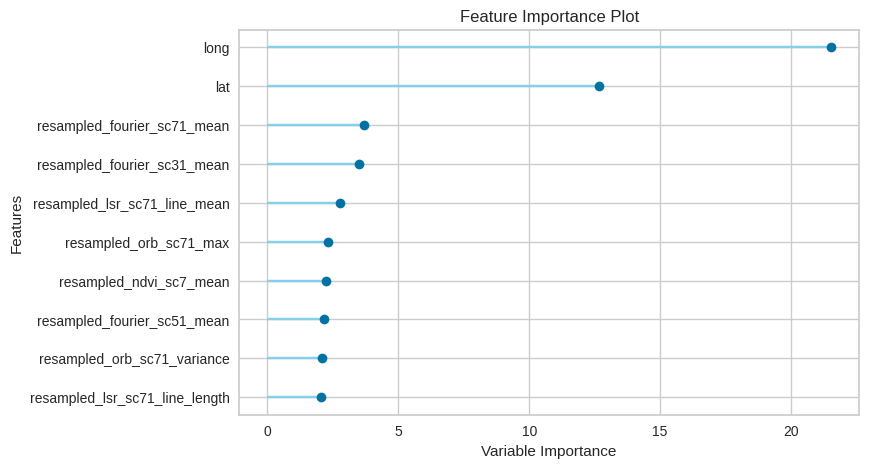

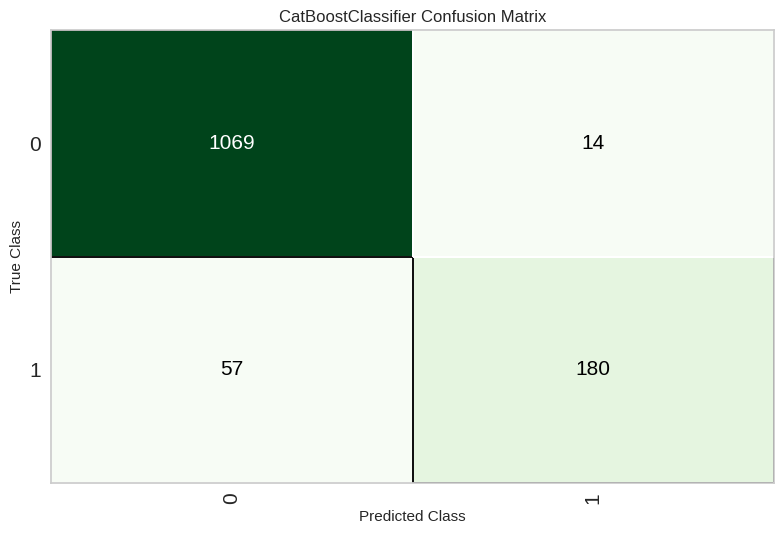

In [ ]:
#Tune best model
tuned_model = tune_model(catboost)

#Feature importance
plot_model(estimator = tuned_model, plot = 'feature')

#Plotting the confusion Matrix
plot_model(estimator = tuned_model, plot = 'confusion_matrix')

In [ ]:
# Load the saved experiment
loaded_experiment = load_experiment('/content/sample_data/my_saved_experiment_nairobi_contextual', data = train_data)
print(load_experiment)
# Set up the loaded experiment
#setup_from_loaded = loaded_experiment['setup']
# Access the trained model
#saved_gbc_model = loaded_experiment['models']['gbc']

,Description,Value
0,Session id,4987
1,Target,Slum
2,Target type,Binary
3,Original data shape,"(4400, 147)"
4,Transformed data shape,"(4400, 147)"
5,Transformed train set shape,"(3080, 147)"
6,Transformed test set shape,"(1320, 147)"
7,Numeric features,144
8,Categorical features,2
9,Preprocess,True


<function load_experiment at 0x7f5232981630>


In [ ]:
'''save_model(lightgbm, 'saved_lightgbm_model')
save_model(gbc, 'saved_gbc_model')
save_model(rf, 'saved_rf_model')
save_model(xgboost, 'saved_xgboost_model')
save_model(et, 'saved_et_model')
save_model(ada, 'saved_ada_model')
save_model(dt, 'saved_dt_model')
save_model(qda, 'saved_qda_model')
save_model(lda, 'saved_lda_model')
save_model(ridge, 'saved_ridge_model')
save_model(lr, 'saved_lr_model')
save_model(svm, 'saved_svm_model')
save_model(dummy, 'saved_dummy_model')
save_model(nb, 'saved_nb_model')
save_model(mlp, 'saved_mlp_model')
save_model(catboost, 'saved_catboost_model')'''

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['resampled_fourier_sc31_mean',
                                              'resampled_fourier_sc31_variance',
                                              'resampled_fourier_sc51_mean',
                                              'resampled_fourier_sc51_variance',
                                              'resampled_fourier_sc71_mean',
                                              'resampled_fourier_sc71_variance',
                                              'resampled_gabor_sc3_filter_1',
                                              'resampled_gabor_sc3...
                                                               strategy='most_frequent'))),
                 ('rest_encoding',
                  TransformerWrapper(exclude=None, include=['lat', 'long'],
                                     transfor

In [ ]:
test_df = pd.read_csv('/content/sample_data/joint_nairobi.csv')
test_df = test_df.drop(['Unnamed: 0.1', 'Unnamed: 0', 'id_left', 'created_at', 'user_id', 'user_background', 'user_map_usage', 'user_location','output_id', 'output_model', 'output_model_city_name', 'output_model_city_country', 'output_model_subdomain_name','output_result', 'label'], axis=1)
saved_dt_model = load_model('/content/sample_data/saved_dt_model')

test_df = test_df.drop(['distance', 'index_right', 'VALUE', 'id_right', 'bgrn_1', 'bgrn_2', 'bgrn_3', 'bgrn_4'], axis = 1)
test_df = test_df.rename(columns={'output_latitude': 'lat', 'output_longitude': 'long'})
#test_df.columns = test_df.columns.str.replace('resampled_', '')


test_df = test_df.reindex(sorted(test_df.columns), axis=1)

test_df = test_df.drop(test_df.columns[0:53], axis=1)
test_df = test_df.drop(['geometry'], axis = 1)

#print(test_df.columns)

colsNorm = test_df.columns[2:-1]
#print(colsNorm)

test_df[colsNorm] = si.fit_transform(test_df[colsNorm])
test_df[colsNorm] = ss.fit_transform(test_df[colsNorm])

test_df = test_df.reindex(sorted(test_df.columns), axis=1)
#
#print(test_df['output_result'])
#print(test_df.head())

predictions = predict_model(saved_dt_model, data = test_df)

print(predictions.head())
#print(predictions['output_result'])
predictions.to_csv('predictions_dt_nairobi.csv')

Transformation Pipeline and Model Successfully Loaded


        lat       long  resampled_fourier_sc31_mean  \
0 -1.249989  36.888756                     0.573934   
1 -1.249989  36.888756                     0.573934   
2 -1.249180  36.888748                    -0.563375   
3 -1.249180  36.888748                    -0.563375   
4 -1.252415  36.886780                    -1.372137   

   resampled_fourier_sc31_variance  resampled_fourier_sc51_mean  \
0                        -0.892174                     0.201682   
1                        -0.892174                     0.201682   
2                        -0.145902                    -0.270110   
3                        -0.145902                    -0.270110   
4                         0.489811                    -1.243353   

   resampled_fourier_sc51_variance  resampled_fourier_sc71_mean  \
0                        -1.156627                    -0.018798   
1                        -1.156627                    -0.018798   
2                        -1.017970                     0.568843  

In [ ]:
#test_df.columns = test_df.columns.str.replace('resampled_', '')
#test_df = test_df.reindex(sorted(test_df.columns), axis=1)
#test_df['Slum']
test_df = test_df.drop(['output_result'], axis=1)
#test_df = test_df.rename(columns={'output_result':'Slum'})
print(test_df.columns)
print(test_df.head())
print(saved_gbc_model.feature_names_in_)
predictions_proba = saved_gbc_model.predict_proba(test_df)
print(predictions_proba)
predictions_proba = pd.DataFrame(predictions_proba)
predictions_proba.to_csv('predictions_proba_gbc_nairobi.csv')

Index(['lat', 'long', 'resampled_fourier_sc31_mean',
       'resampled_fourier_sc31_variance', 'resampled_fourier_sc51_mean',
       'resampled_fourier_sc51_variance', 'resampled_fourier_sc71_mean',
       'resampled_fourier_sc71_variance', 'resampled_gabor_sc3_filter_1',
       'resampled_gabor_sc3_filter_10',
       ...
       'resampled_sfs_sc51_mean', 'resampled_sfs_sc51_min_line_length',
       'resampled_sfs_sc51_std', 'resampled_sfs_sc51_w_mean',
       'resampled_sfs_sc71_max_line_length',
       'resampled_sfs_sc71_max_ratio_of_orthogonal_angles',
       'resampled_sfs_sc71_mean', 'resampled_sfs_sc71_min_line_length',
       'resampled_sfs_sc71_std', 'resampled_sfs_sc71_w_mean'],
      dtype='object', length=146)
        lat       long  resampled_fourier_sc31_mean  \
0 -1.249989  36.888756                     0.573934   
1 -1.249989  36.888756                     0.573934   
2 -1.249180  36.888749                    -0.563375   
3 -1.249180  36.888749                    -0.563